# Exploratory Data Analysis

This notebook provides an Exploratory Data Analysis (EDA) of the MovieLens 25M dataset, examining its multiple components (including movies, ratings, tags, links, and genome data) to uncover structural insights, assess data quality, and identify patterns relevant to building a recommendation system.

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import sweetviz as sv
import glob

## Data Loading

In [4]:
# Check if the parquet files exists
if len(glob.glob("./data/parquet/*.parquet")) != 6:
    # if not create the parquet files
    movies = pd.read_csv("./data/csv/movies.csv")
    tags = pd.read_csv("./data/csv/tags.csv")
    genome_tags = pd.read_csv("./data/csv/genome-tags.csv")
    links = pd.read_csv("./data/csv/links.csv")
    ratings = pd.read_csv("./data/csv/ratings.csv")
    genome_scores = pd.read_csv("./data/csv/genome-scores.csv")
    # Movies
    movies.to_parquet("./data/parquet/movies.parquet")
    # Tags
    tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')
    tags.to_parquet("./data/parquet/tags.parquet")
    # genome_tags
    genome_tags.to_parquet("./data/parquet/genome_tags.parquet")
    # links
    # tmdbId is float because of missing values
    links.to_parquet("./data/parquet/links.parquet")
    # ratings
    ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
    ratings.to_parquet("./data/parquet/ratings.parquet")
    # genome_scores
    genome_scores.to_parquet("./data/parquet/genome_scores.parquet")
else:
    # if yes then read the parquet files
    movies = pd.read_parquet("./data/parquet/movies.parquet")
    tags = pd.read_parquet("./data/parquet/tags.parquet")
    genome_tags = pd.read_parquet("./data/parquet/genome_tags.parquet")
    links = pd.read_parquet("./data/parquet/links.parquet")
    ratings = pd.read_parquet("./data/parquet/ratings.parquet")
    genome_scores = pd.read_parquet("./data/parquet/genome_scores.parquet")

## EDA

### Movies

In [3]:
movies.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


The movies.csv DataFrame contains 62423 entries and 3 columns: movieId, title, and genres. Each column has a complete set of non-null values, indicating no missing data. The movieId is stored as an integer and serves as a unique identifier for each movie. Both title and genres are stored as objects (strings), where title includes the movie name and release year, and genres lists one or more genres in a pipe-separated format. The dataset occupies approximately 1.4 MB of memory, and its clean, consistent structure makes it suitable for further analysis and integration with other MovieLens datasets.

In [4]:
movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy


Missing values:
 movieId    0
title      0
genres     0
dtype: int64
Unique movies: 62423

Year range: 1874 - 2019


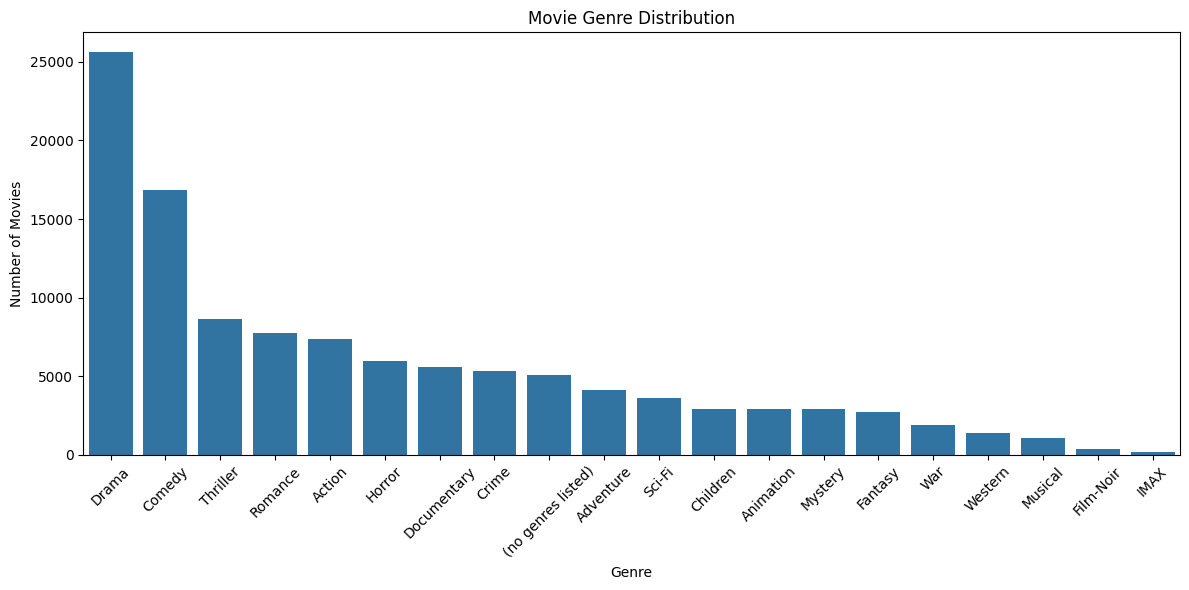

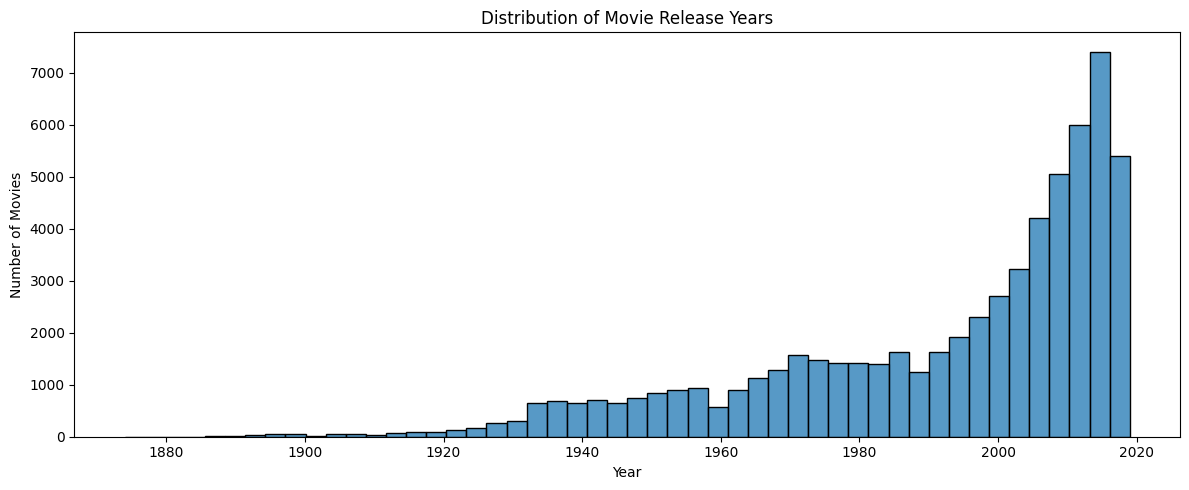

In [5]:
print("\nMissing values:\n", movies.isnull().sum())

# Number of unique movies
print("Unique movies:", movies['movieId'].nunique())

# Extracting year from title
movies['year'] = movies['title'].str.extract(r"\((\d{4})\)").astype('float')
print("\nYear range:", int(movies['year'].min()), "-", int(movies['year'].max()))

# Genre distribution
genre_split = movies['genres'].str.split('|').explode()
genre_counts = genre_split.value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xticks(rotation=45)
plt.title('Movie Genre Distribution')
plt.ylabel('Number of Movies')
plt.xlabel('Genre')
plt.tight_layout()
plt.show()

# Release year histogram
plt.figure(figsize=(12, 5))
sns.histplot(movies['year'].dropna(), bins=50, kde=False)
plt.title('Distribution of Movie Release Years')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.show()

The movies.csv dataset contains 62423 unique movie records, each with complete information across three columns: movieId, title, and genres. There are no missing values in the dataset, which ensures high reliability for downstream processing. The genre distribution shows that the most common movie categories are Drama and Comedy, with over 25000 and 16000 movies respectively, followed by Thriller, Romance, and Action. A small subset of entries have no genre listed. This indicates a strong presence of narrative-driven content in the dataset, with less representation for niche genres like IMAX or Film-Noir.

The release year distribution reveals a steadily increasing number of movie entries over time, with very few movies before the 1920s, and a significant rise in production from the 1980s onward. The data peaks around 2015–2018, reflecting both actual production trends and the greater digital availability of modern films. The earliest recorded release year is 1874, although early entries may reflect data artifacts or historical film records. This temporal range offers rich potential for time-aware analysis or modeling user preferences across different cinematic eras.

In [6]:
# Check for full duplicate rows
full_duplicates = movies[movies.duplicated()]
print(f"Number of fully duplicated rows: {len(full_duplicates)}")
if not full_duplicates.empty:
    print(full_duplicates)

# Check for duplicate movieId
duplicate_ids = movies[movies.duplicated('movieId', keep=False)]
print(f"\nNumber of duplicate movieIds: {len(duplicate_ids)}")
if not duplicate_ids.empty:
    print(duplicate_ids.sort_values('movieId'))

# Check for duplicate title+year combinations
movies['year'] = movies['title'].str.extract(r"\((\d{4})\)")
duplicate_titles = movies[movies.duplicated(['title', 'year'], keep=False)]
print(f"\nNumber of duplicate titles with same year: {len(duplicate_titles)}")
if not duplicate_titles.empty:
    print(duplicate_titles.sort_values(['title', 'year']))

Number of fully duplicated rows: 0

Number of duplicate movieIds: 0

Number of duplicate titles with same year: 196
       movieId                     title  \
13713    71057                  9 (2009)   
61103   204982                  9 (2009)   
30628   136696         Absolution (2015)   
37060   151797         Absolution (2015)   
580        588            Aladdin (1992)   
...        ...                       ...   
49653   179333           Veronica (2017)   
10055    34048  War of the Worlds (2005)   
12909    64997  War of the Worlds (2005)   
17391    91199            Weekend (2011)   
50600   181385            Weekend (2011)   

                                            genres  year  
13713                   Adventure|Animation|Sci-Fi  2009  
61103                                       Comedy  2009  
30628              Action|Adventure|Crime|Thriller  2015  
37060                               Drama|Thriller  2015  
580    Adventure|Animation|Children|Comedy|Musical  1992  
.

The movies.csv dataset has no fully duplicated rows and no repeated movieId values, confirming that each entry is uniquely identified and the dataset structure is sound for joining with other files. However, there are 196 cases where different movieId values are associated with identical movie titles and release years. These duplicates in title and year combinations suggest the presence of alternate versions, remakes, or inconsistent metadata—such as re-releases or region-specific versions of the same film. While this doesn't pose a structural issue, it may affect content-based recommendation models or aggregations by title unless normalized or resolved during preprocessing.

### Tags

In [7]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1093360 entries, 0 to 1093359
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   userId     1093360 non-null  int64         
 1   movieId    1093360 non-null  int64         
 2   tag        1093344 non-null  object        
 3   timestamp  1093360 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 33.4+ MB


The tags.csv DataFrame contains 1093360 entries across four columns: userId, movieId, tag, and timestamp. All columns except tag are fully populated, with only 16 missing values in the tag field. The userId, movieId, and timestamp columns are stored as integers, while tag is an object type representing free-text input from users. The dataset occupies approximately 33.4 MB of memory and reflects user-generated metadata applied to movies. Given the near-complete data and structured identifiers, this dataset is well-suited for exploring user interests, enhancing content metadata, or incorporating semantic signals into recommendation systems.

In [8]:
tags.head()

userId  movieId               tag           timestamp
0       3      260           classic 2015-08-13 13:25:55
1       3      260            sci-fi 2015-08-13 13:24:16
2       4     1732       dark comedy 2019-11-16 22:33:18
3       4     1732    great dialogue 2019-11-16 22:33:24
4       4     7569  so bad it's good 2019-11-16 22:30:55


Missing values:
 userId        0
movieId       0
tag          16
timestamp     0
dtype: int64
Unique users: 14592
Unique movies: 45251
Unique tags: 73050


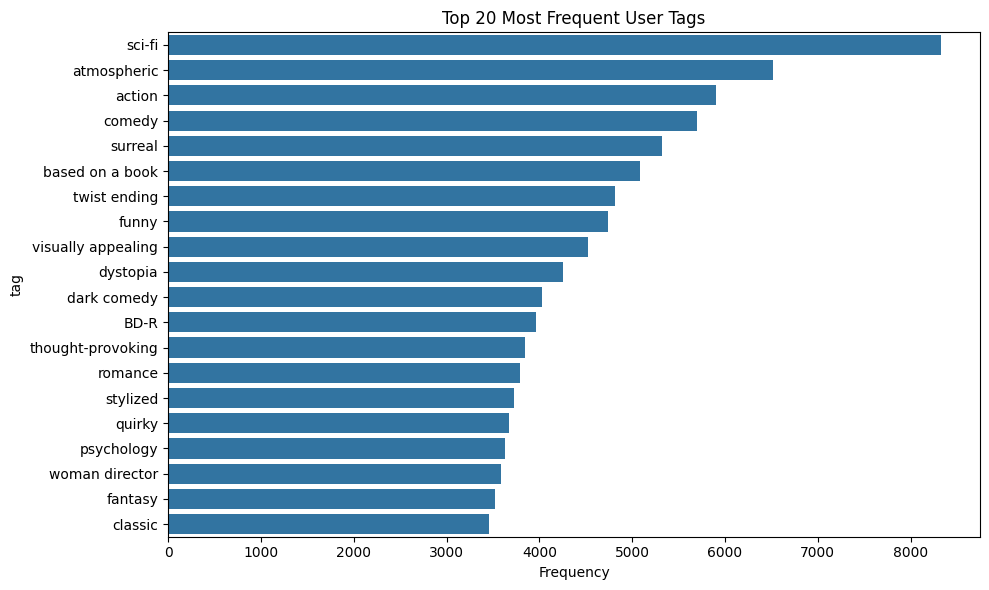

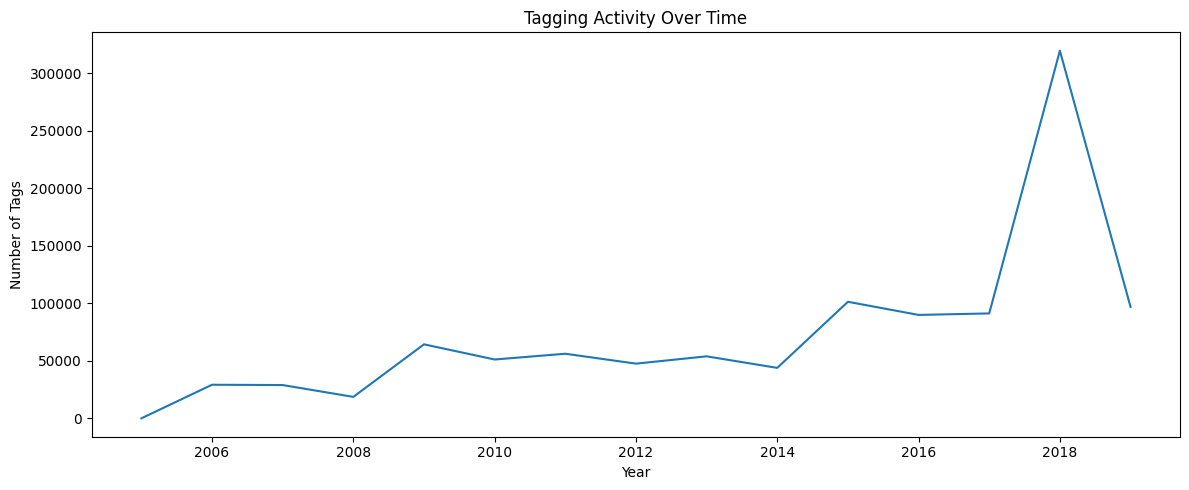

In [9]:
# Missing values
print("\nMissing values:\n", tags.isnull().sum())

# Number of unique values
print("Unique users:", tags['userId'].nunique())
print("Unique movies:", tags['movieId'].nunique())
print("Unique tags:", tags['tag'].nunique())

# Tag frequency
top_tags = tags['tag'].value_counts().head(20)

plt.figure(figsize=(10, 6))
sns.barplot(y=top_tags.index, x=top_tags.values, orient='h')
plt.title('Top 20 Most Frequent User Tags')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

tags['datetime'] = pd.to_datetime(tags['timestamp'], unit='s')
tags['year'] = tags['datetime'].dt.year

# Tagging activity over time
tag_counts_by_year = tags['year'].value_counts().sort_index()

plt.figure(figsize=(12, 5))
sns.lineplot(x=tag_counts_by_year.index, y=tag_counts_by_year.values)
plt.title('Tagging Activity Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Tags')
plt.tight_layout()
plt.show()

Each tag is associated with a userId, movieId, and timestamp, and only 16 entries have missing tag values, indicating a very clean dataset. There are 14592 unique users who tagged 45251 different movies using a total of 73050 unique tag phrases. This highlights the diversity and richness of user-generated content in the dataset.

The most frequently used tags include general descriptors like sci-fi, atmospheric, action, comedy, and surreal, suggesting that users tend to tag movies based on genre, tone, or stylistic elements. Some tags, such as woman director or based on a book, add contextual or production-level metadata that can be useful for more nuanced recommendation systems.

Temporal analysis of tagging activity reveals a gradual rise in participation from 2005 onward, with a significant peak around 2018. This suggests increased user engagement or a possible change in the tagging interface or promotion on the MovieLens platform during that period. Overall, the tags dataset provides valuable semantic and user-driven insights that complement numeric ratings and genre metadata.

### Genome Tags

In [10]:
genome_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tagId   1128 non-null   int64 
 1   tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


The genome-tags.csv DataFrame contains 1128 entries and 2 columns: tagId and tag. Each entry maps a unique numerical identifier to a standardized tag label, with no missing values in either column. The tagId is an integer, while tag is an object type representing descriptive terms such as "dark comedy" or "visually appealing." This compact dataset, occupying approximately 17.8 KB of memory, defines the vocabulary used in the Tag Genome and serves as a reference for interpreting the relevance scores in genome-scores.csv. Its structure ensures consistency in tag usage across all movies and facilitates reliable content-based feature construction.

In [11]:
genome_tags.head()

tagId           tag
0      1           007
1      2  007 (series)
2      3  18th century
3      4         1920s
4      5         1930s

In [12]:
# Missing values
print("\nMissing values:\n", genome_tags.isnull().sum())

# Unique tags and IDs
print("Number of unique tagIds:", genome_tags['tagId'].nunique())
print("Number of unique tags:", genome_tags['tag'].nunique())

# Tag length stats
genome_tags['tag_length'] = genome_tags['tag'].str.len()
print("\nTag length stats:\n", genome_tags['tag_length'].describe())

# Sample of long/short/interesting tags
print("\nLongest tags:\n", genome_tags.sort_values(by="tag_length", ascending=False).head(10))
print("\nShortest tags:\n", genome_tags.sort_values(by="tag_length").head(10))


Missing values:
 tagId    0
tag      0
dtype: int64
Number of unique tagIds: 1128
Number of unique tags: 1128

Tag length stats:
 count    1128.000000
mean       10.020390
std         5.351242
min         2.000000
25%         6.000000
50%         9.000000
75%        12.000000
max        65.000000
Name: tag_length, dtype: float64

Longest tags:
      tagId                                                tag  tag_length
759    760  oscar (best writing - screenplay written direc...          65
338    339        easily confused with other movie(s) (title)          43
879    880           saturn award (best science fiction film)          40
751    752              oscar (best effects - visual effects)          37
880    881                saturn award (best special effects)          35
753    754                oscar (best music - original score)          35
752    753                 oscar (best foreign language film)          34
754    755                 oscar (best music - original song

The genome-tags.csv dataset contains 1128 standardized tags, each uniquely identified by a tagId. There are no missing values, and the tag vocabulary is fully unique and clean. The tags vary in length from short descriptors like “art” and “dog” (3 characters) to more detailed phrases like “oscar (best writing - screenplay written directly for the screen)”, which is the longest at 65 characters. The average tag length is approximately 10 characters, indicating a mix of concise and descriptive labeling.

This controlled vocabulary provides a consistent and interpretable set of semantic attributes used in the tag genome. It supports the construction of content-based recommendation features by ensuring that every movie is evaluated against the same standardized set of descriptors. The presence of both thematic (e.g., “sad”) and structural (e.g., “nonlinear timeline”) tags allows for multidimensional modeling of movie content.

### Links

In [13]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  62423 non-null  int64  
 1   imdbId   62423 non-null  int64  
 2   tmdbId   62316 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


The links.csv DataFrame contains 62423 entries and 3 columns: movieId, imdbId, and tmdbId. All entries have non-null values for movieId and imdbId, while tmdbId has 107 missing values, indicating that a small number of movies do not have an associated entry in The Movie Database (TMDb). The movieId and imdbId are stored as integers, while tmdbId is stored as a float due to the presence of missing values. This dataset uses consistent movie identifiers from external sources, enabling linkage of MovieLens data with rich metadata from IMDb and TMDb for tasks such as metadata enrichment, movie poster retrieval, and cross-platform comparison.

In [14]:
links.head()

movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0


Missing values:
 movieId      0
imdbId       0
tmdbId     107
dtype: int64
Unique movieIds: 62423
Unique imdbIds: 62423
Unique tmdbIds: 62281

Duplicate IMDb IDs:
Empty DataFrame
Columns: [movieId, imdbId, tmdbId]
Index: []

Duplicate TMDb IDs:
       movieId    imdbId    tmdbId
675        690    111613  105045.0
706        721    114103       NaN
715        730    125877       NaN
754        770     38426       NaN
775        791    113610       NaN
...        ...       ...       ...
60681   203881  10575038       NaN
61521   206117  10376068  604196.0
61576   206282   8773020       NaN
62339   208799   4035866       NaN
62343   208806   2625082       NaN

[176 rows x 3 columns]


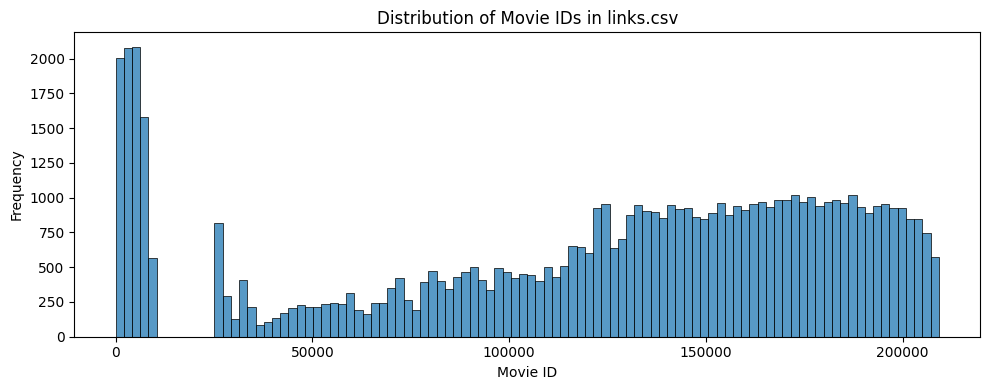

In [15]:
# Missing values
print("\nMissing values:\n", links.isnull().sum())

# Number of unique values
print("Unique movieIds:", links['movieId'].nunique())
print("Unique imdbIds:", links['imdbId'].nunique())
print("Unique tmdbIds:", links['tmdbId'].nunique())

# Duplicates check
duplicate_imdb = links[links.duplicated('imdbId', keep=False)]
duplicate_tmdb = links[links.duplicated('tmdbId', keep=False)]

print(f"\nDuplicate IMDb IDs:\n{duplicate_imdb}")
print(f"\nDuplicate TMDb IDs:\n{duplicate_tmdb}")

# Movie ID distribution
plt.figure(figsize=(10, 4))
sns.histplot(links['movieId'], bins=100)
plt.title('Distribution of Movie IDs in links.csv')
plt.xlabel('Movie ID')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

The links.csv dataset links MovieLens movies to external databases using imdbId and tmdbId, with 62423 entries corresponding to unique movieId values. All imdbId values are present and unique, while tmdbId is missing for 107 entries, and 176 tmdbId values are duplicated—likely due to missing or mismatched TMDb mappings for different versions of the same movie.

The distribution of movieId values shows a clustered pattern, with dense groupings in lower and upper ranges, reflecting the ID assignment practices in MovieLens. This variation does not affect analysis but might require normalization in certain applications. The clean uniqueness of imdbId ensures reliable integration with IMDb data, while the mostly complete tmdbId column supports enrichment with TMDb resources like movie posters, cast, and keywords. The dataset is well-suited for extending MovieLens metadata via third-party APIs.

### Ratings

In [16]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     int64         
 1   movieId    int64         
 2   rating     float64       
 3   timestamp  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 762.9 MB


The ratings.csv DataFrame contains 25000095 entries across four columns: userId, movieId, rating, and timestamp. All data types are numeric, with userId, movieId, and timestamp stored as integers and rating stored as a float. This large dataset, consuming approximately 763 MB of memory, captures the core user interaction data—each row representing a single user’s rating of a specific movie at a particular point in time. With no missing values and clean structure, the file is ideally suited for collaborative filtering models, user preference analysis, and time-aware recommendation systems.

In [17]:
ratings.head()

userId  movieId  rating           timestamp
0       1      296     5.0 2006-05-17 15:34:04
1       1      306     3.5 2006-05-17 12:26:57
2       1      307     5.0 2006-05-17 12:27:08
3       1      665     5.0 2006-05-17 15:13:40
4       1      899     3.5 2006-05-17 12:21:50


Missing values:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Total ratings: 25000095
Unique users: 162541
Unique movies: 59047


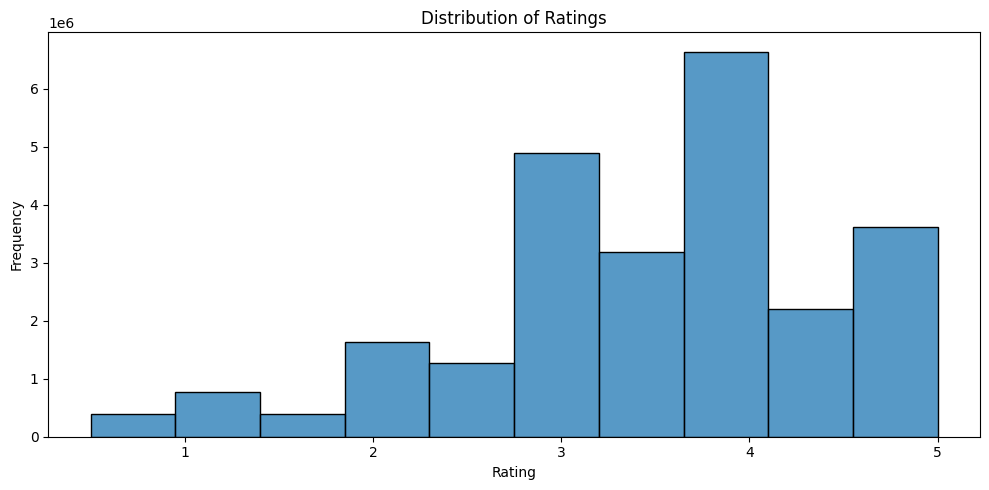

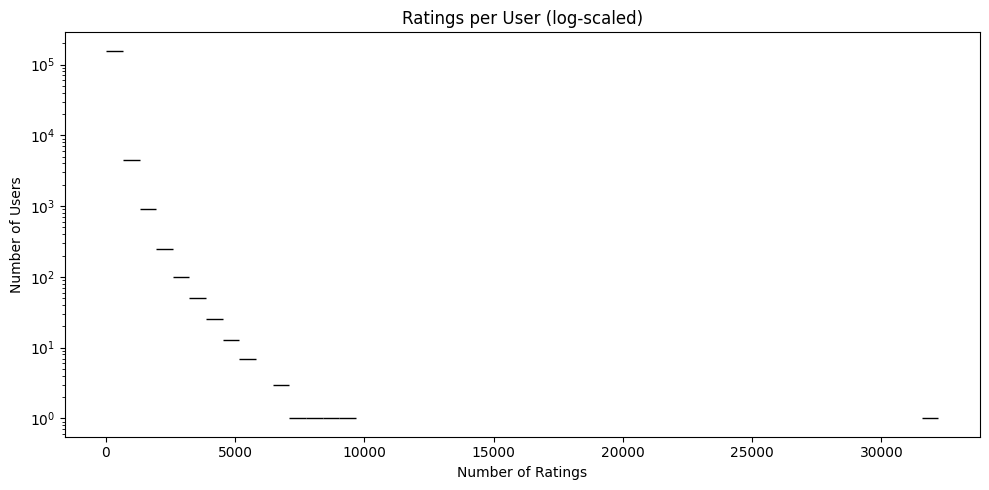

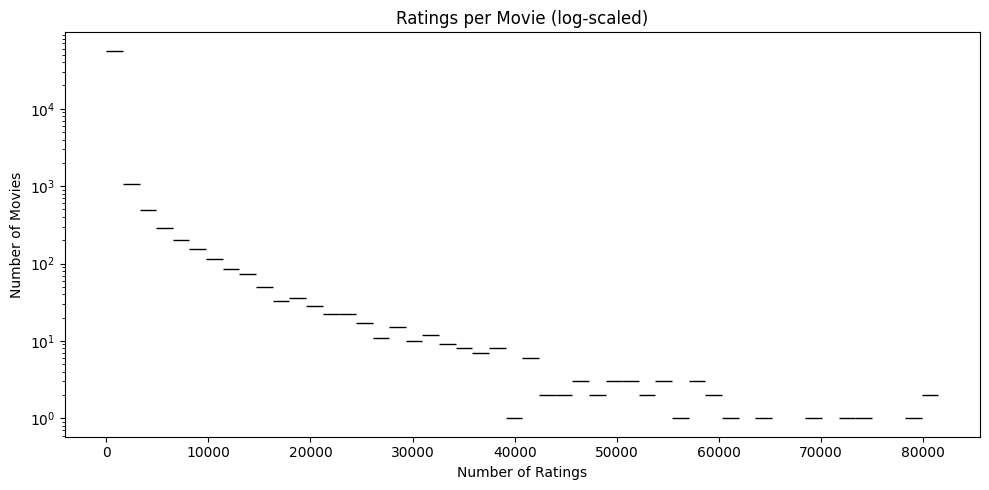

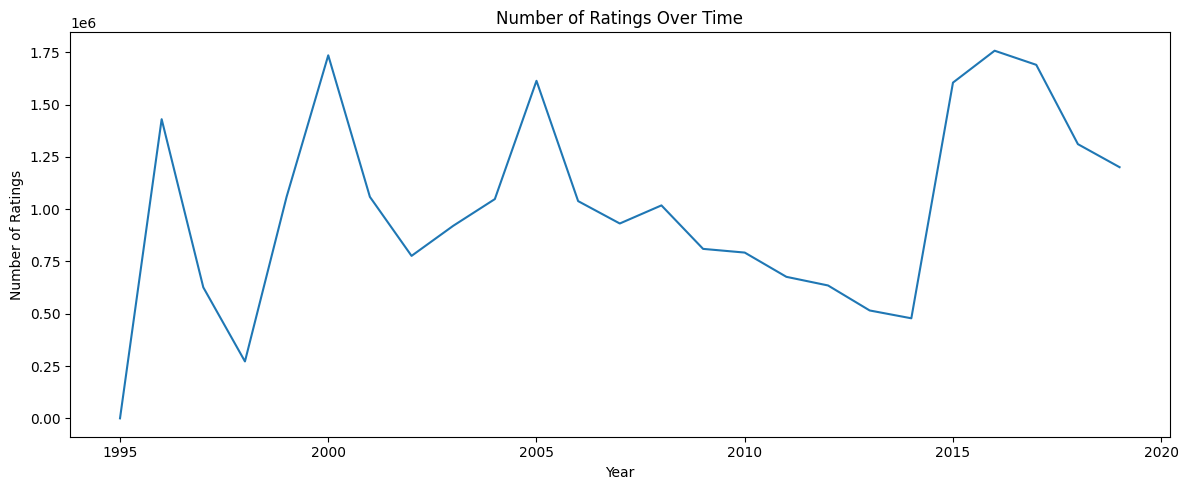

In [18]:


# Missing values
print("\nMissing values:\n", ratings.isnull().sum())

# Unique counts
print("Total ratings:", len(ratings))
print("Unique users:", ratings['userId'].nunique())
print("Unique movies:", ratings['movieId'].nunique())

# Ratings distribution
plt.figure(figsize=(10, 5))
sns.histplot(ratings['rating'], bins=10, kde=False)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Ratings per user
user_counts = ratings['userId'].value_counts()
plt.figure(figsize=(10, 5))
sns.histplot(user_counts, bins=50, log_scale=(False, True))
plt.title('Ratings per User (log-scaled)')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

# Ratings per movie
movie_counts = ratings['movieId'].value_counts()
plt.figure(figsize=(10, 5))
sns.histplot(movie_counts, bins=50, log_scale=(False, True))
plt.title('Ratings per Movie (log-scaled)')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Movies')
plt.tight_layout()
plt.show()

# Convert timestamp
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['year'] = ratings['datetime'].dt.year

# Rating volume over time
ratings_by_year = ratings['year'].value_counts().sort_index()
plt.figure(figsize=(12, 5))
sns.lineplot(x=ratings_by_year.index, y=ratings_by_year.values)
plt.title('Number of Ratings Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.tight_layout()
plt.show()

The ratings.csv file contains 25 million ratings from 162541 users across 59047 movies, with no missing values. Ratings are given on a 0.5 to 5.0 scale in 0.5-point increments. The distribution of ratings is skewed toward the positive end of the scale, with 4.0 being the most common rating, followed by 3.0 and 5.0. This suggests a general positivity bias, which is common in explicit feedback systems.

The log-scaled distribution of ratings per user shows a long-tail pattern, where the majority of users have rated fewer than 100 movies, but a small subset of highly active users have contributed thousands of ratings—up to over 30000 in extreme cases. Similarly, the ratings per movie distribution reveals that while a few popular movies have tens of thousands of ratings, the majority have fewer than 100, indicating sparse coverage across the catalog.

The temporal trend of ratings over time reveals fluctuations in user activity, with notable peaks around 1996, 2000, 2005, and a sharp resurgence in 2015–2017. These patterns may be influenced by the evolution of the MovieLens platform, dataset curation practices, or broader adoption of the service. Overall, this dataset is rich and well-structured, making it ideal for collaborative filtering, trend analysis, and building hybrid recommendation systems.

### Genome Scores

In [19]:
genome_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15584448 entries, 0 to 15584447
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   tagId      int64  
 2   relevance  float64
dtypes: float64(1), int64(2)
memory usage: 356.7 MB


The genome-scores.csv DataFrame contains 15584448 entries across three columns: movieId, tagId, and relevance. Each row represents the relevance score of a specific tag (from the Tag Genome) to a specific movie, with relevance values stored as floats ranging from 0.0 to 1.0. Both movieId and tagId are stored as integers. The dataset has no missing values and occupies approximately 356.7 MB of memory. This file forms a dense movie–tag matrix, where every movie is scored against each of the 1128 standardized tags defined in genome-tags.csv. It is a foundational component for building content-based recommendation systems, enabling fine-grained semantic profiling of movie content.

In [20]:
genome_scores.head()

movieId  tagId  relevance
0        1      1    0.02875
1        1      2    0.02375
2        1      3    0.06250
3        1      4    0.07575
4        1      5    0.14075


Missing values:
 movieId      0
tagId        0
relevance    0
dtype: int64
Unique movies: 13816
Unique tagIds: 1128
Total rows: 15584448


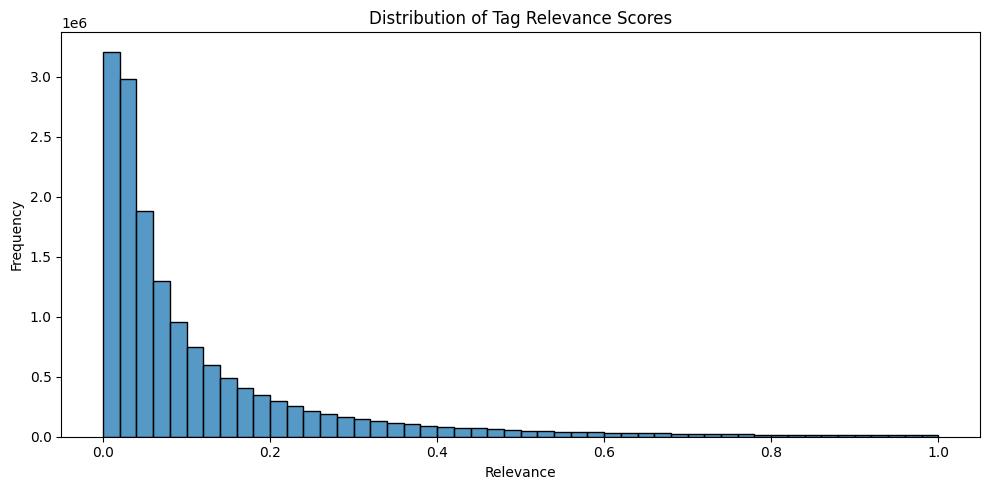


Sample high-relevance tags:
      movieId  tagId  relevance
62         1     63    0.94725
63         1     64    0.98425
185        1    186    0.95475
202        1    203    0.90375
203        1    204    0.95975

Top tags for movieId=1:
       movieId  tagId  relevance
1035        1   1036    0.99925
243         1    244    0.99875
785         1    786    0.99575
588         1    589    0.98575
63          1     64    0.98425
587         1    588    0.98000
784         1    785    0.96450
203         1    204    0.95975
185         1    186    0.95475
62          1     63    0.94725


In [21]:
# Missing values
print("\nMissing values:\n", genome_scores.isnull().sum())

# Basic stats
print("Unique movies:", genome_scores['movieId'].nunique())
print("Unique tagIds:", genome_scores['tagId'].nunique())
print("Total rows:", len(genome_scores))

# Relevance distribution
plt.figure(figsize=(10, 5))
sns.histplot(genome_scores['relevance'], bins=50)
plt.title('Distribution of Tag Relevance Scores')
plt.xlabel('Relevance')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Sample high-relevance tags
high_relevance = genome_scores[genome_scores['relevance'] > 0.9]
print("\nSample high-relevance tags:\n", high_relevance.head())

# Top tags for a random movie
movie_sample = genome_scores[genome_scores['movieId'] == 1].sort_values(by='relevance', ascending=False).head(10)
print("\nTop tags for movieId=1:\n", movie_sample)

The genome-scores.csv dataset provides a dense mapping of semantic relevance scores between 13816 movies and 1128 standardized tags, totaling over 15.5 million rows. Each entry assigns a relevance score (ranging from 0.0 to 1.0) to indicate how strongly a given tag applies to a specific movie. There are no missing values, and the data is cleanly structured for analytical use.

The distribution of relevance scores is highly skewed toward the lower end, with the majority of tag associations having low relevance values. This reflects the fact that most tags are only weakly relevant or irrelevant to most movies. High relevance scores—generally above 0.9—are relatively rare and represent core thematic descriptors of a movie. For example, for movieId=1, tags with the highest relevance scores exceed 0.98, indicating a strong association with the underlying content.

This dataset enables fine-grained content profiling by transforming movies into high-dimensional tag vectors. It is especially useful for content-based recommendation systems, hybrid models, and user profiling when combined with user rating histories. Its dense and standardized nature makes it ideal for similarity computation and feature-based retrieval tasks.

## Sweetviz

                                             |          | [  0%]   00:00 -> (? left)


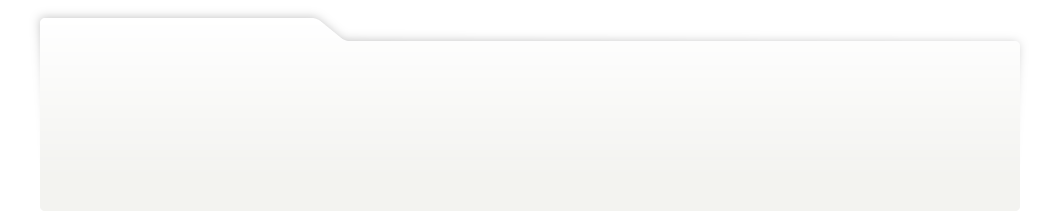
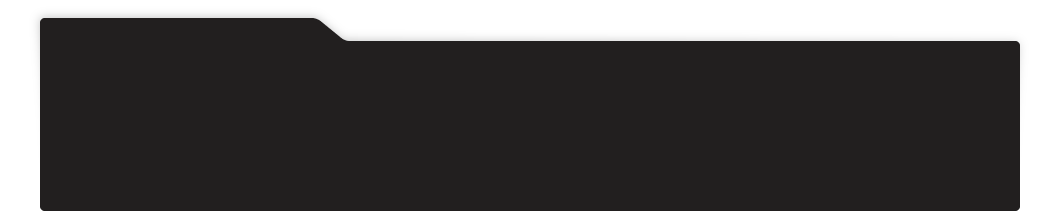
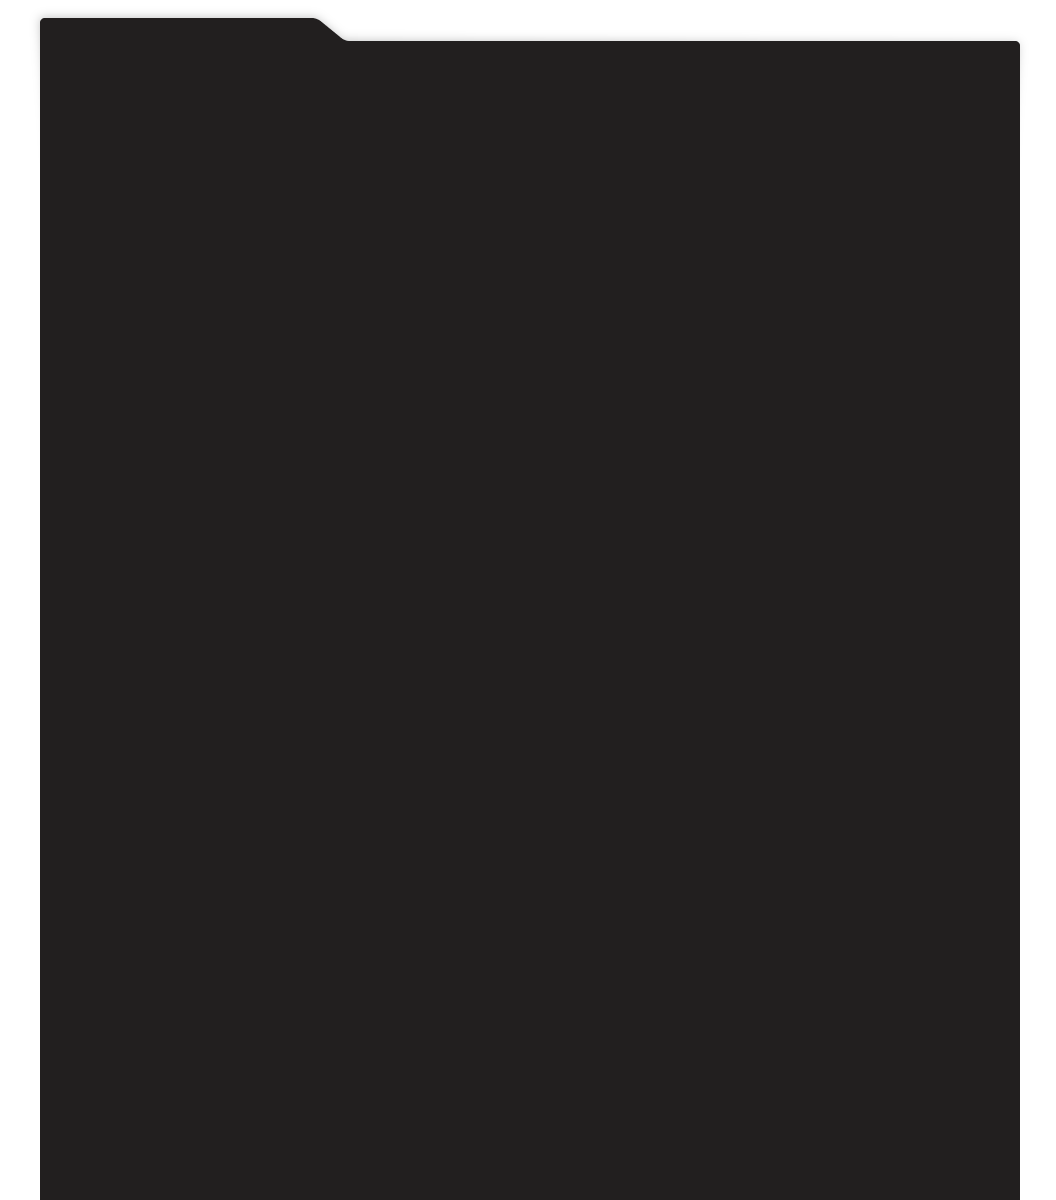
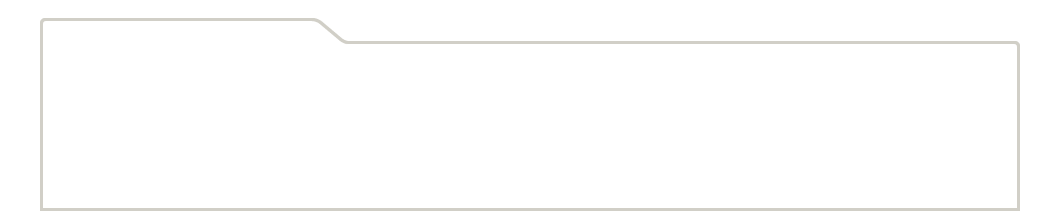
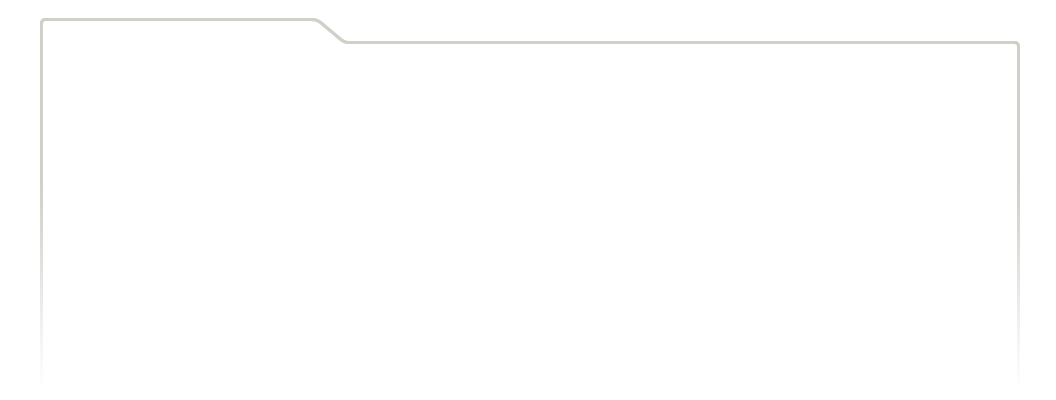
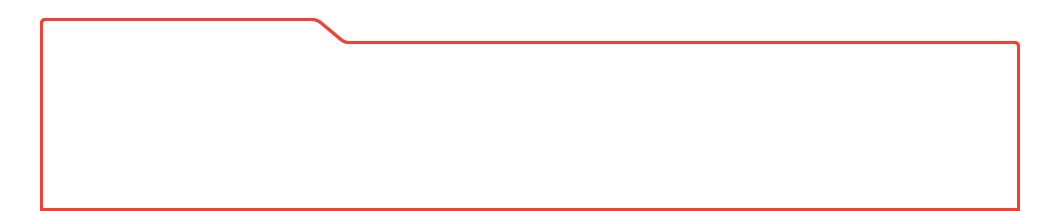
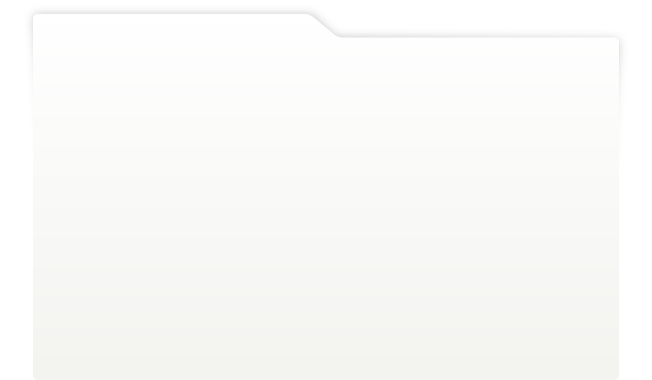
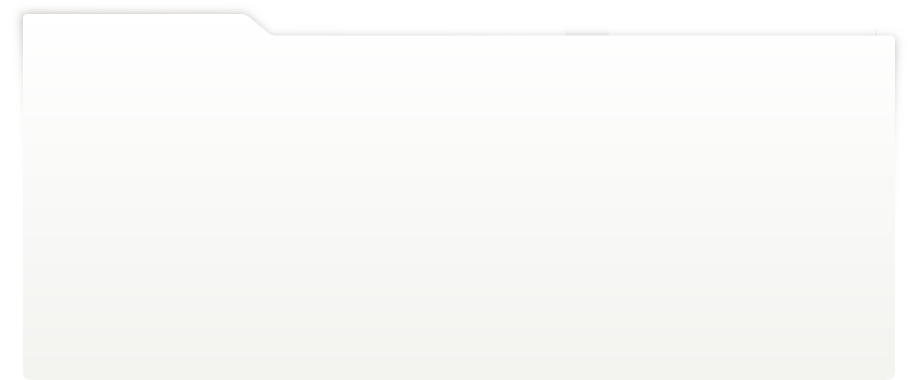
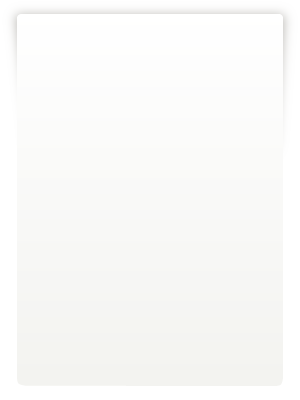
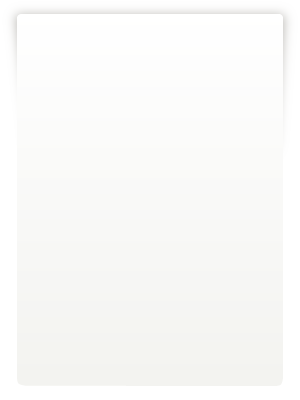
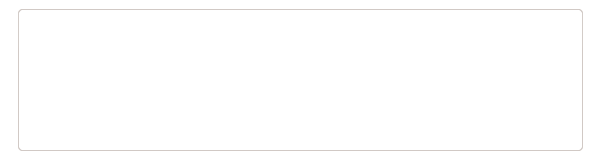
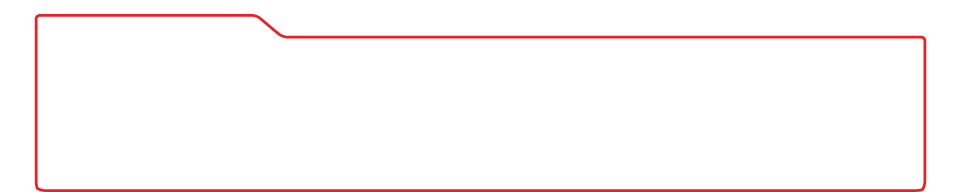
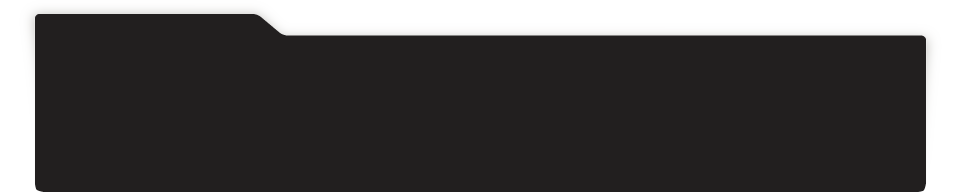
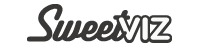
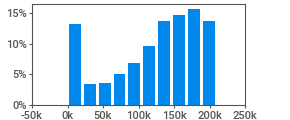
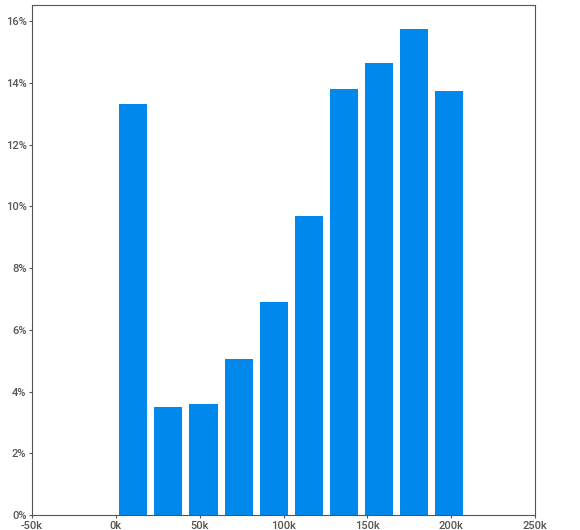
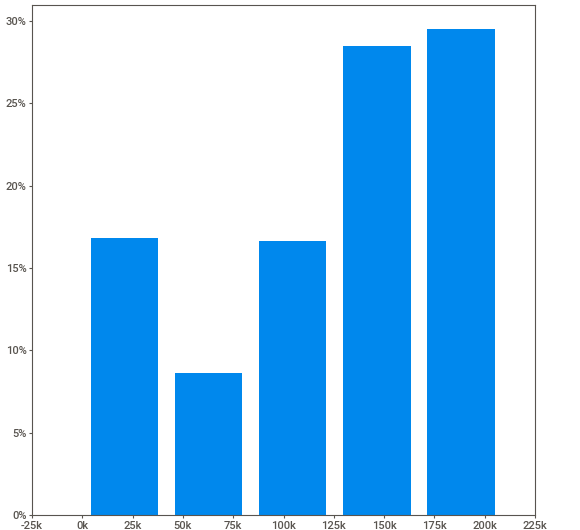
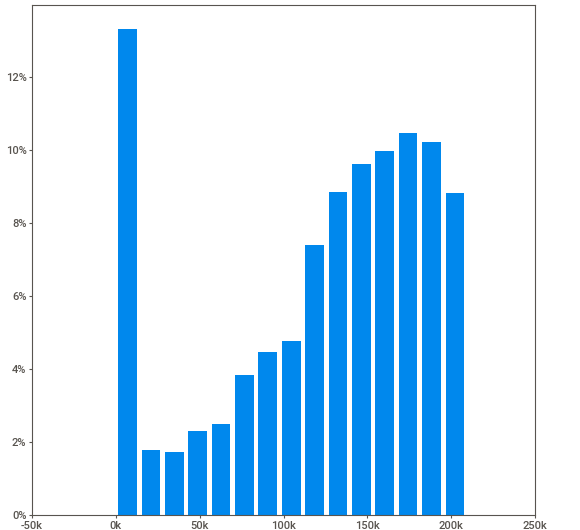
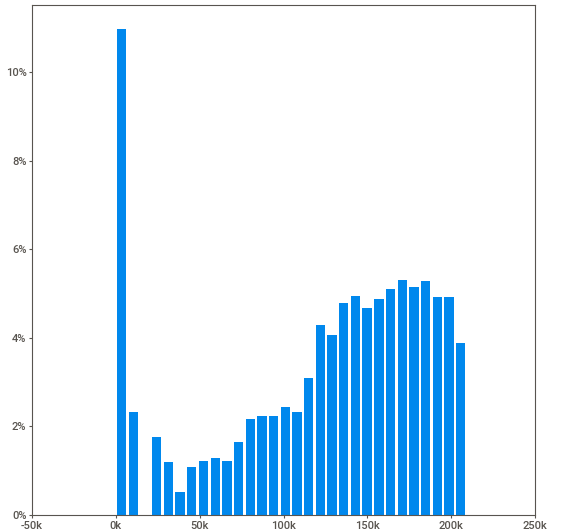
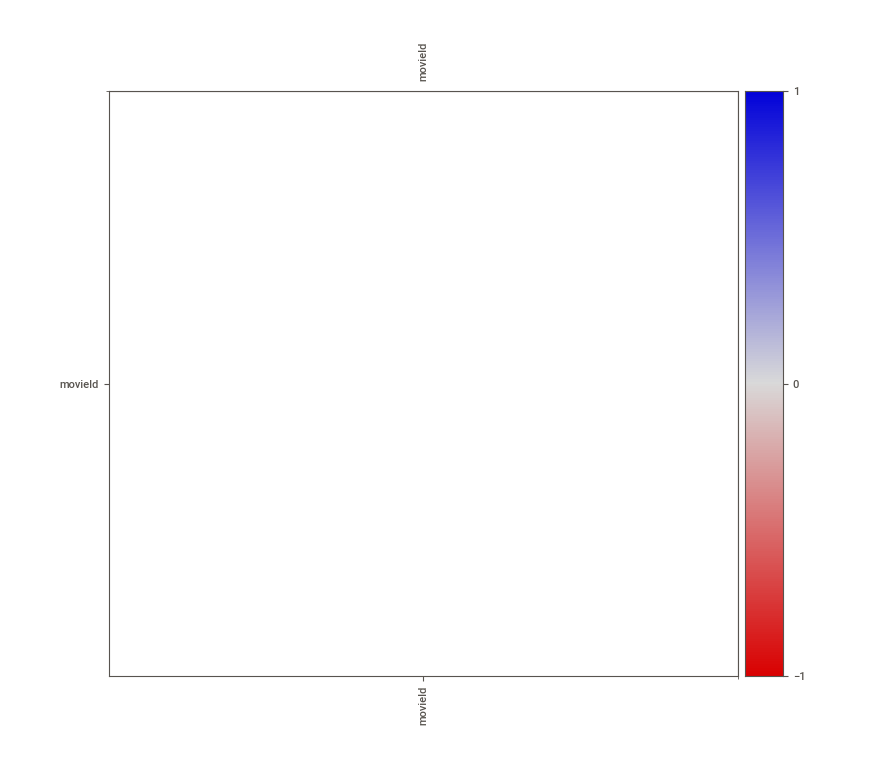
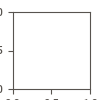

In [22]:
sv_movies_report = sv.analyze(movies)
sv_movies_report.show_notebook()

                                             |          | [  0%]   00:00 -> (? left)


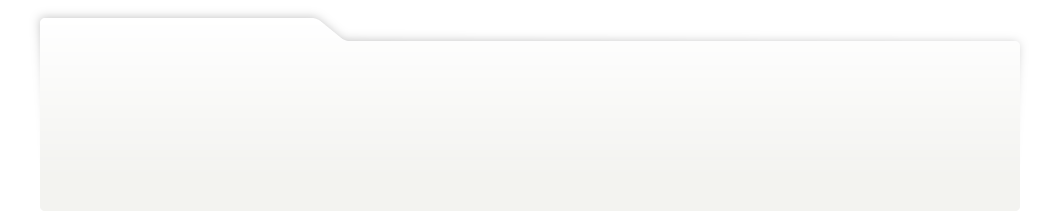
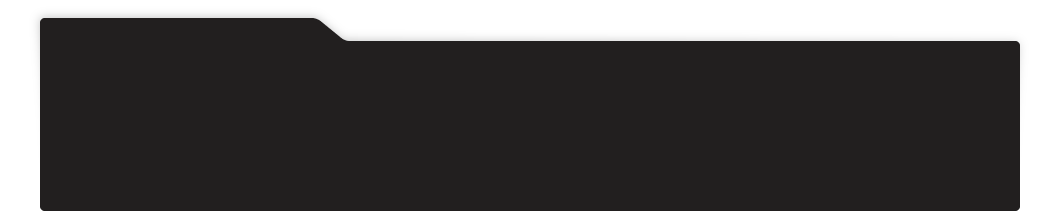
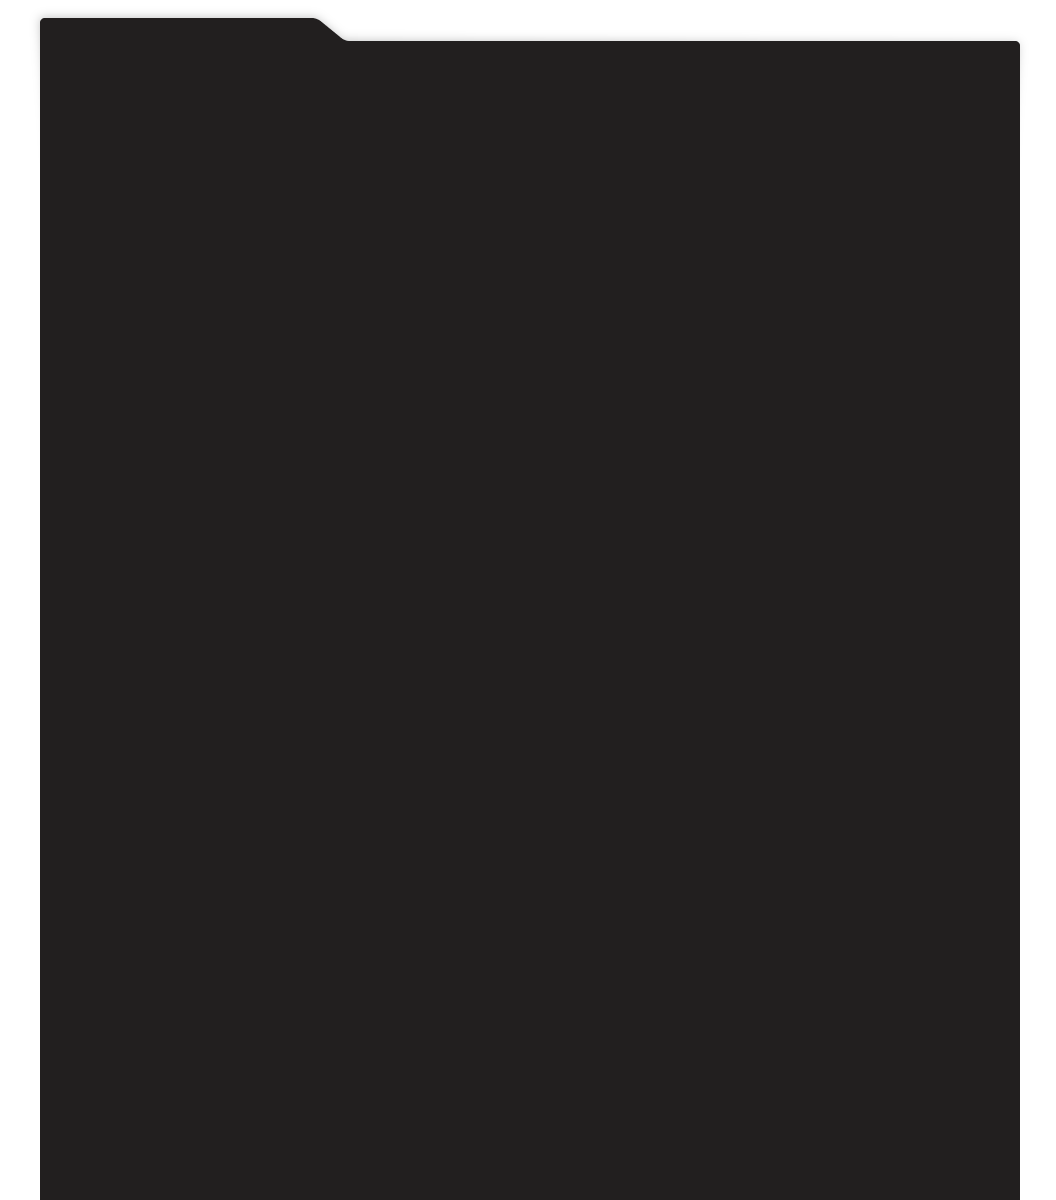
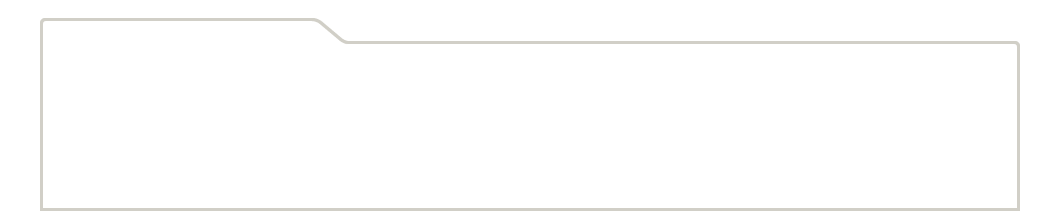
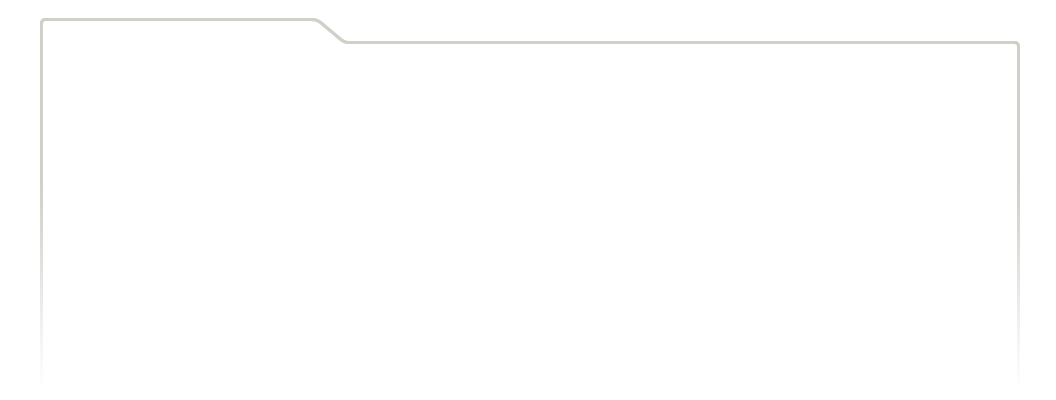
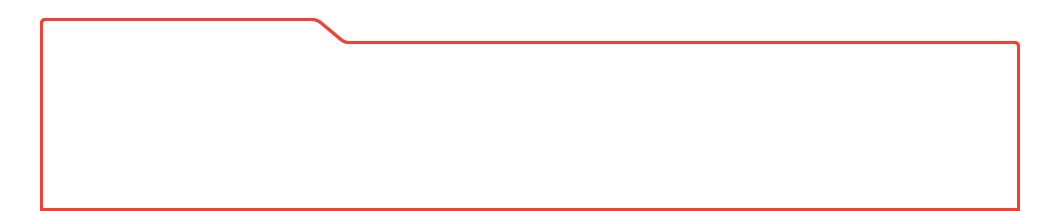
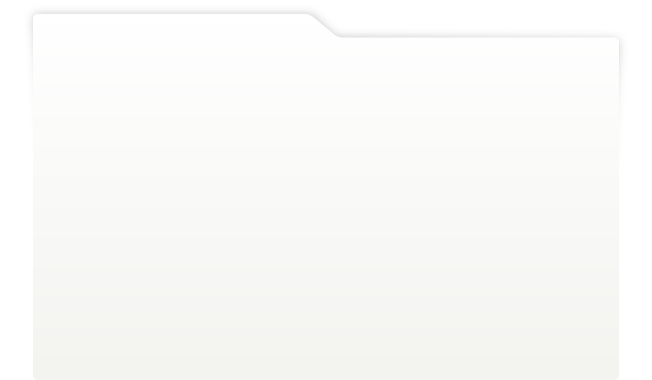
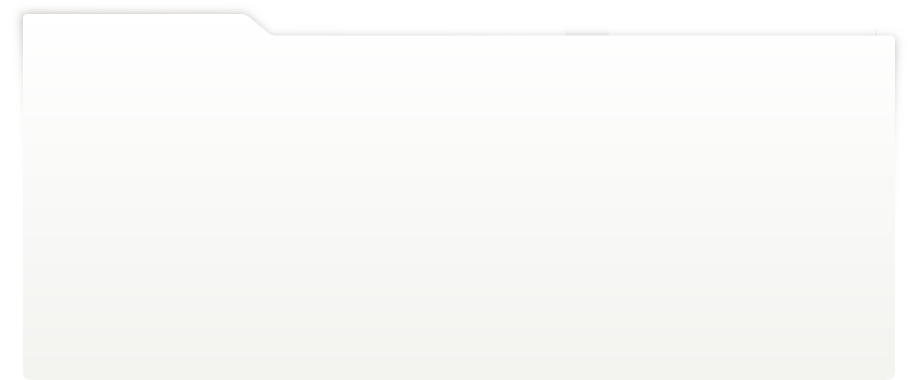
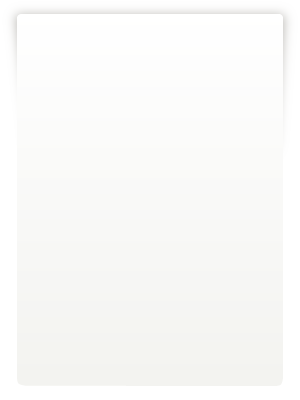
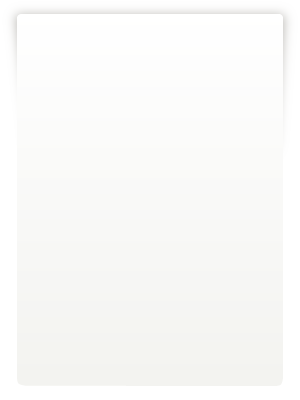
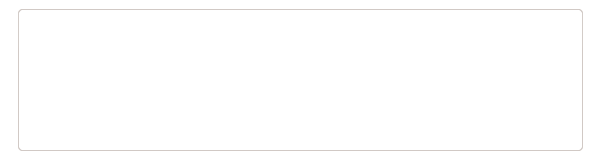
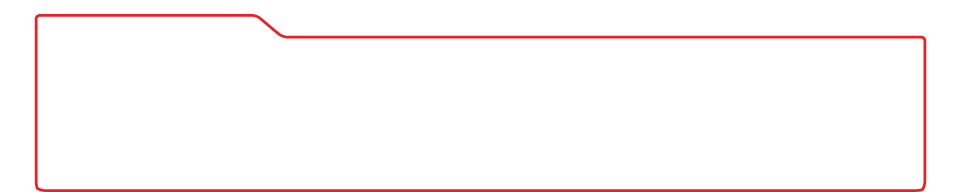
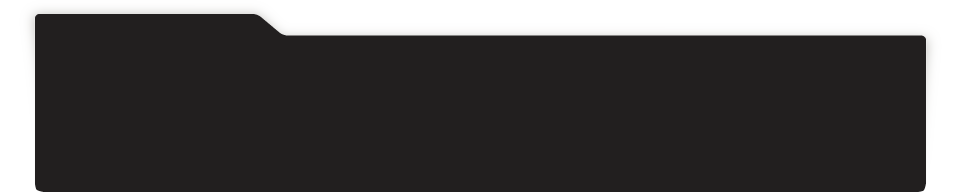
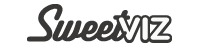
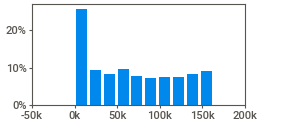
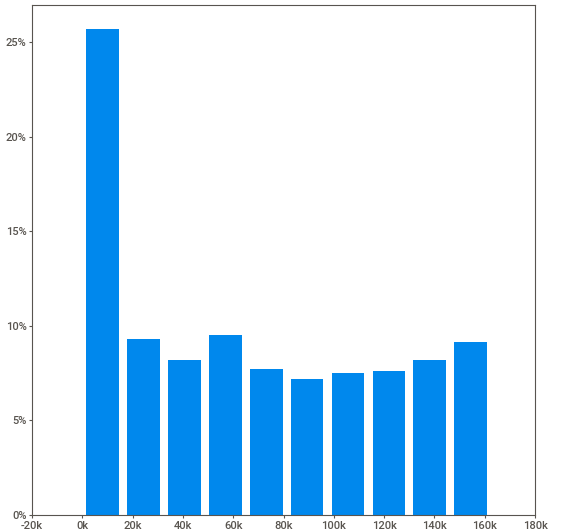
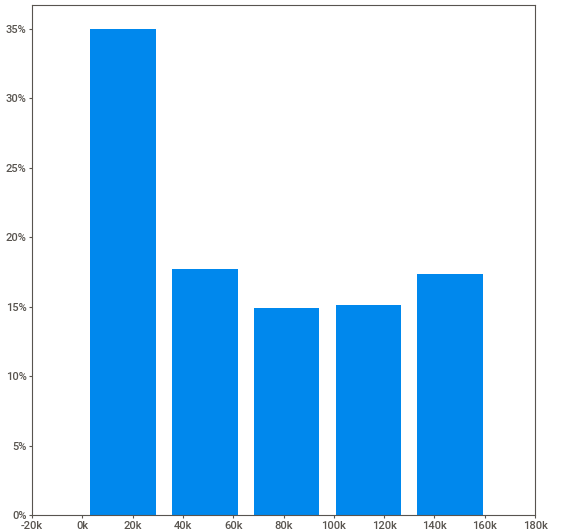
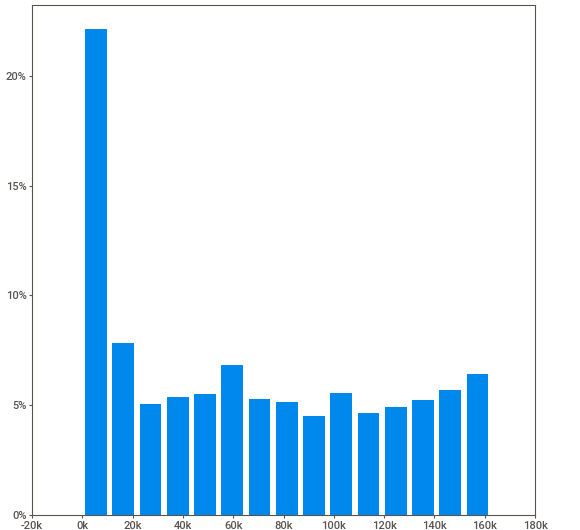
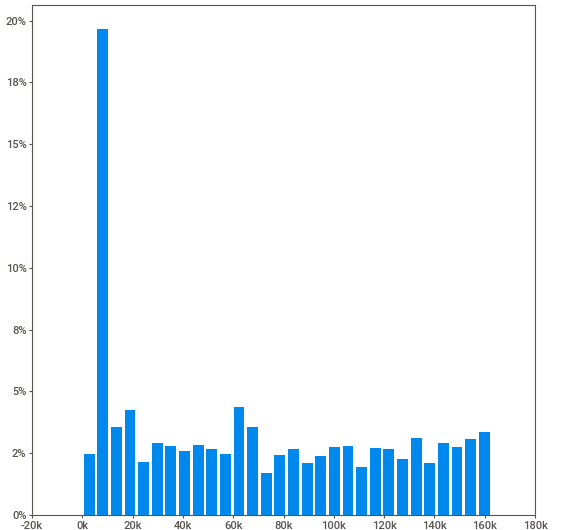
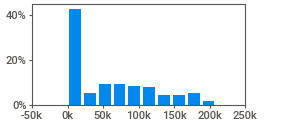
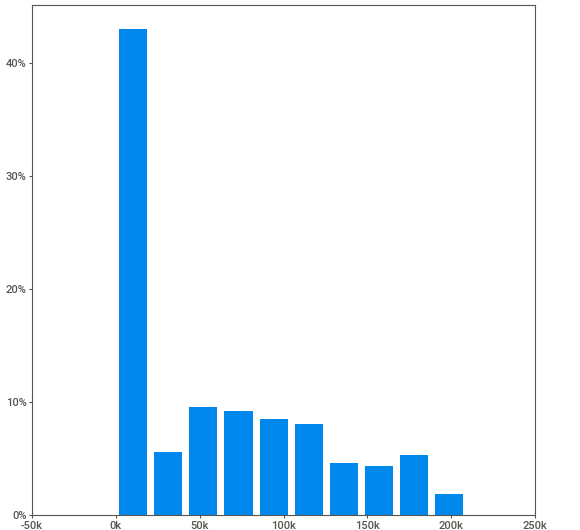
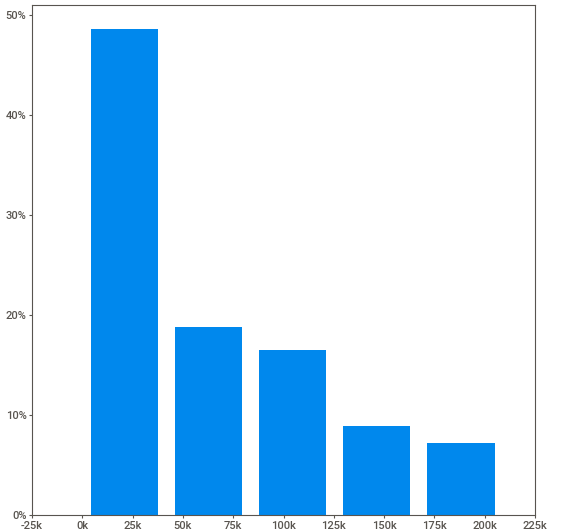
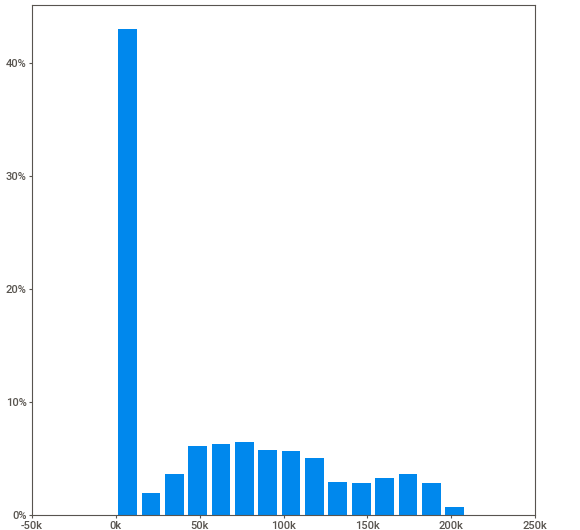
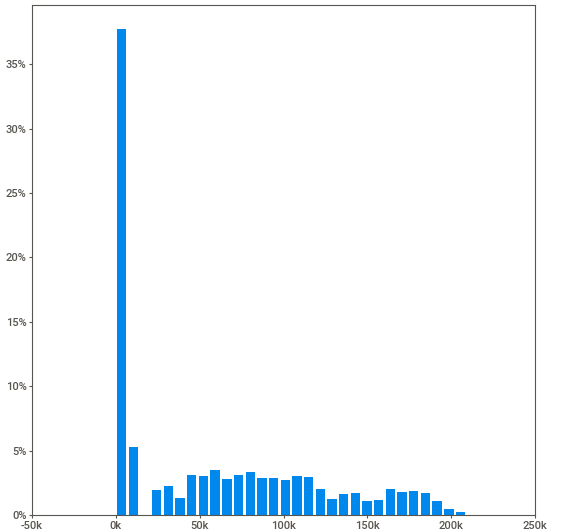
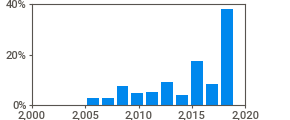
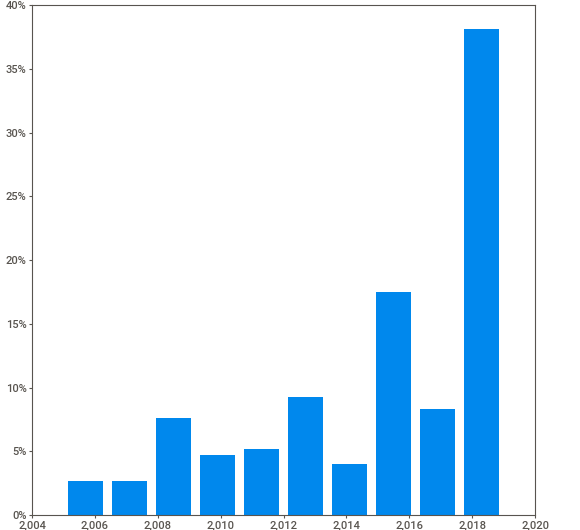
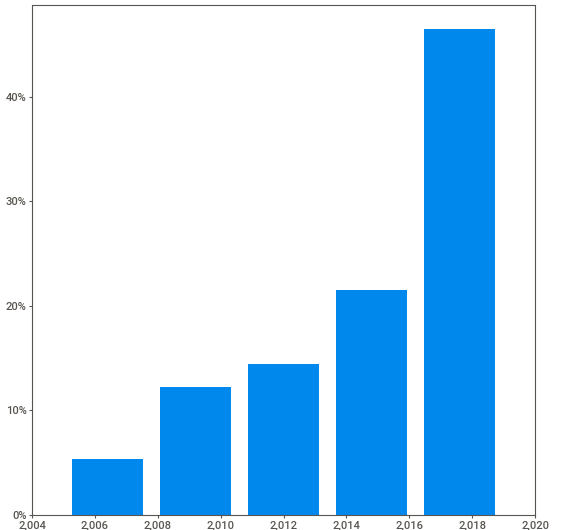
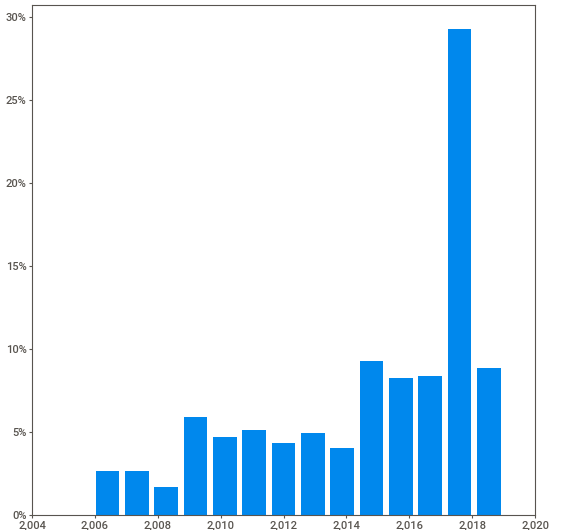
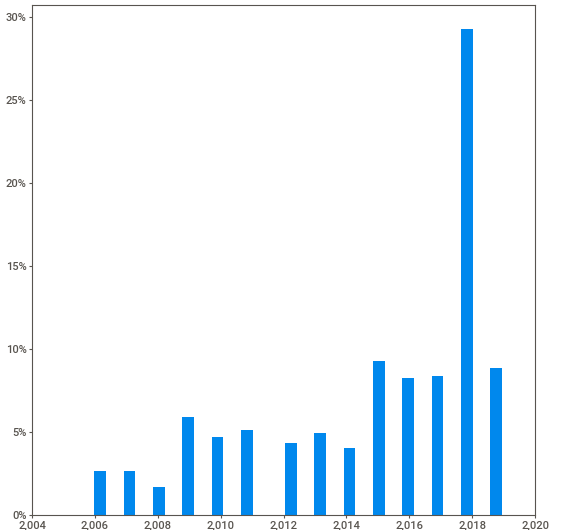
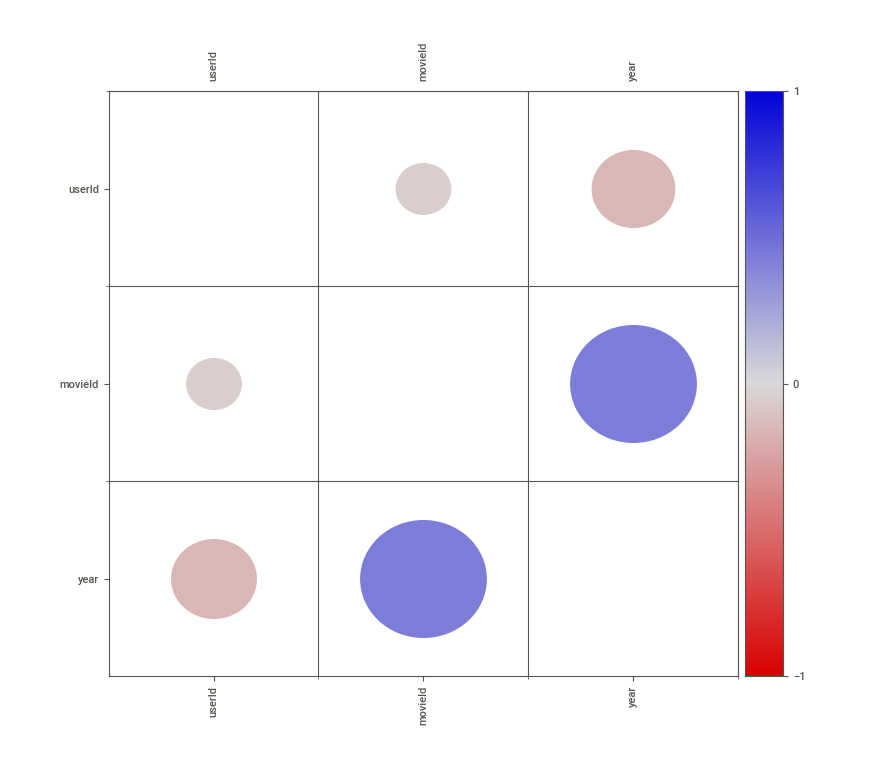
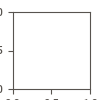

In [23]:
sv_tags_report = sv.analyze(tags)
sv_tags_report.show_notebook()

                                             |          | [  0%]   00:00 -> (? left)


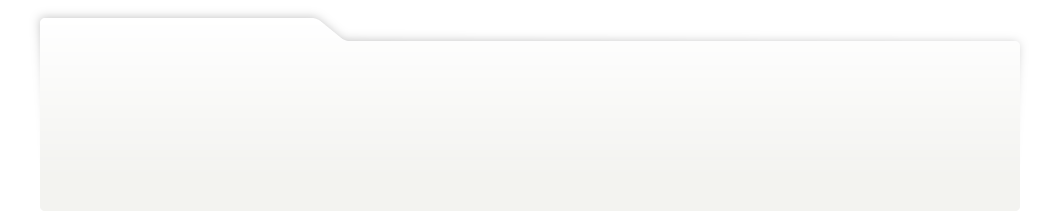
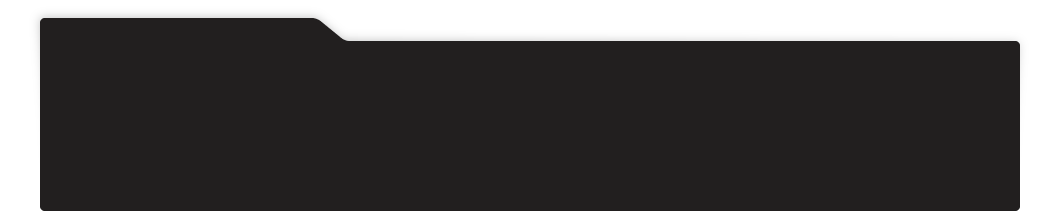
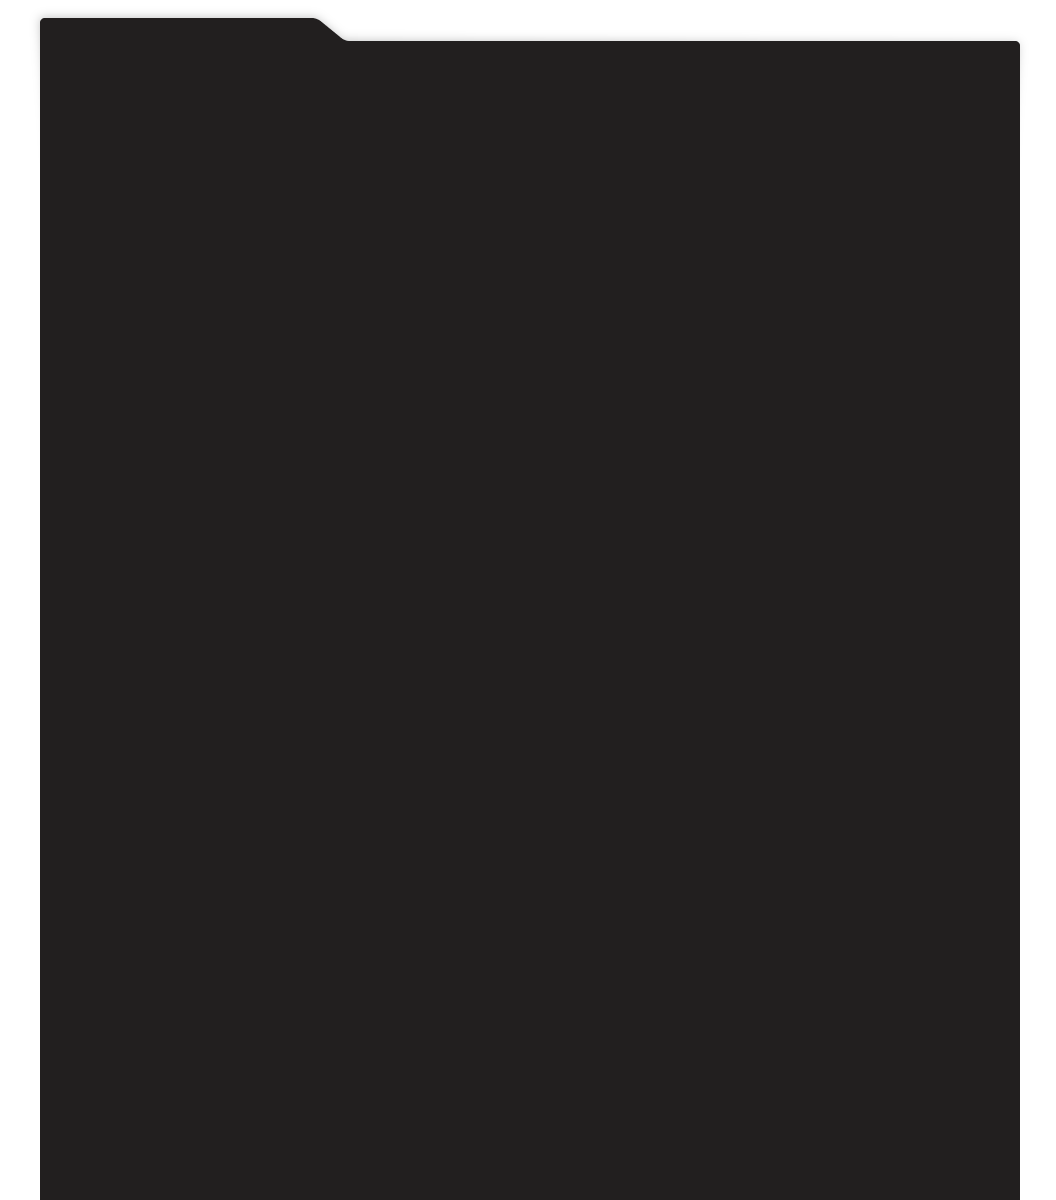
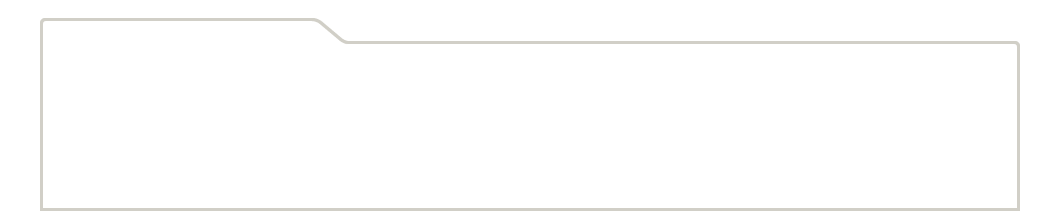
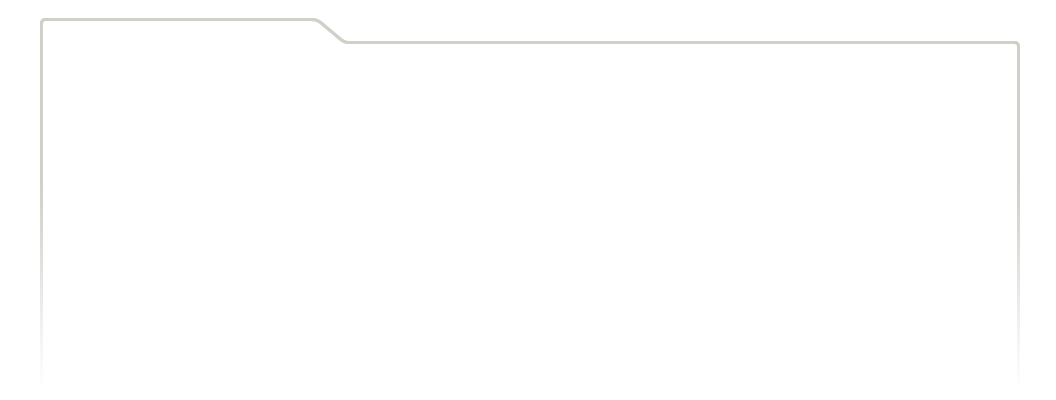
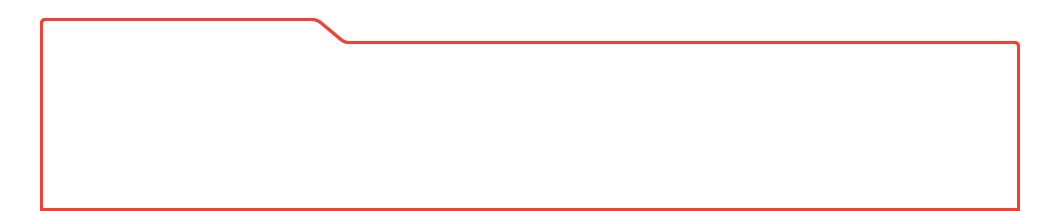
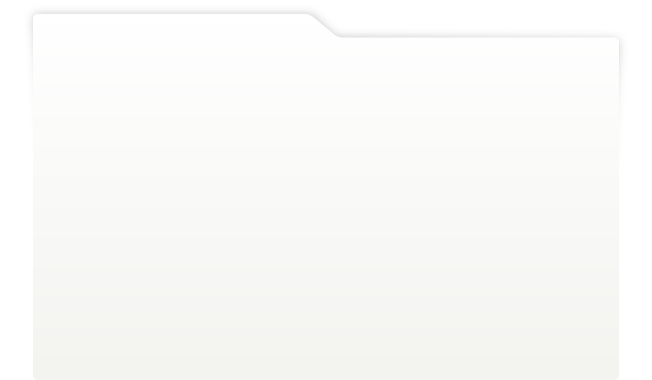
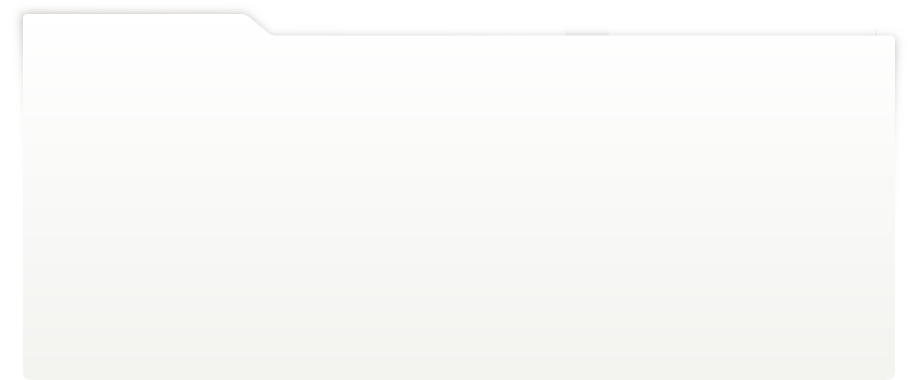
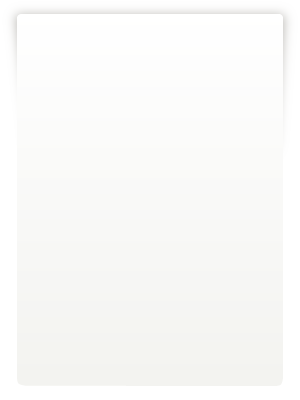
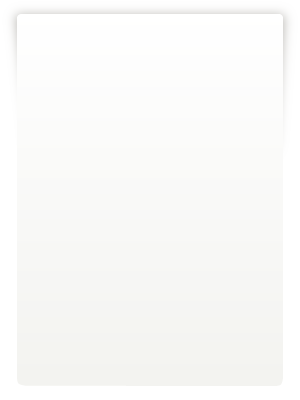
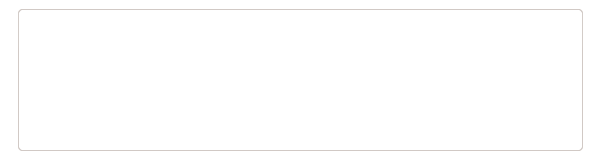
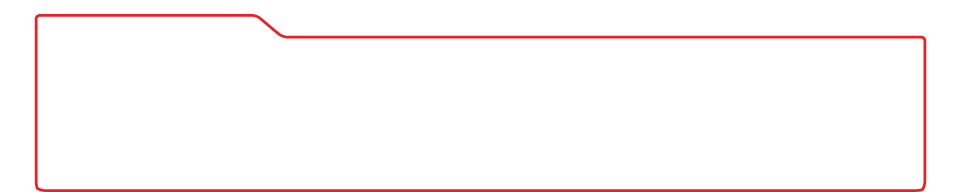
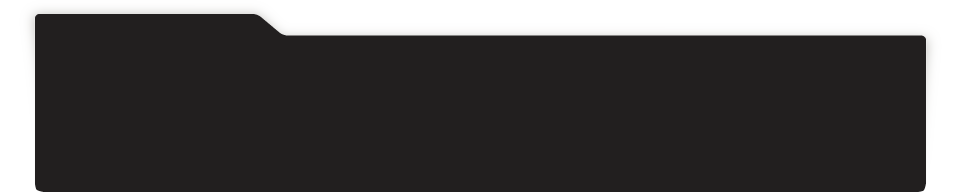
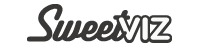
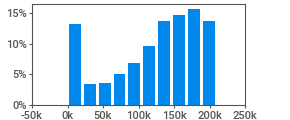
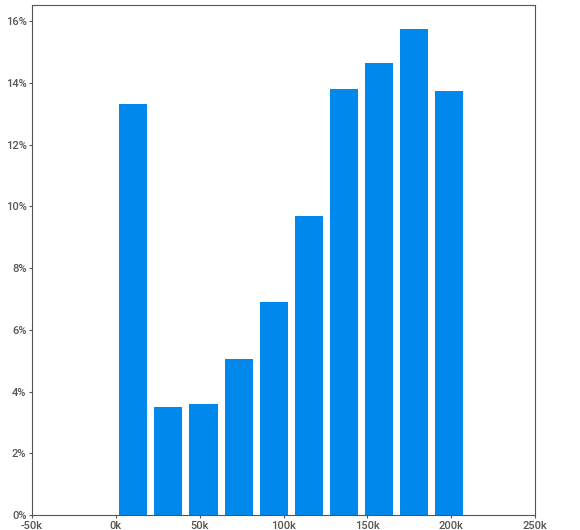
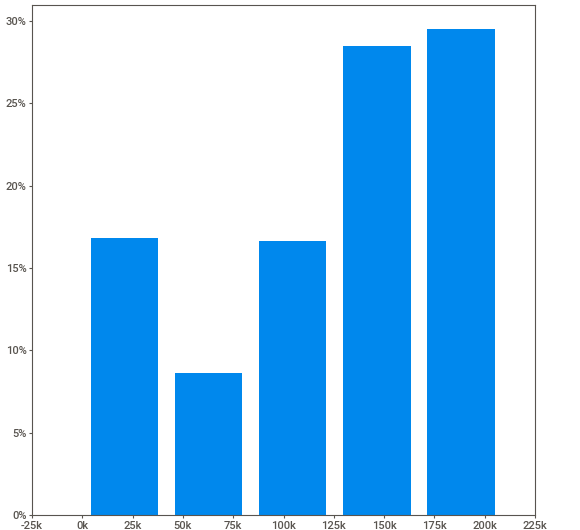
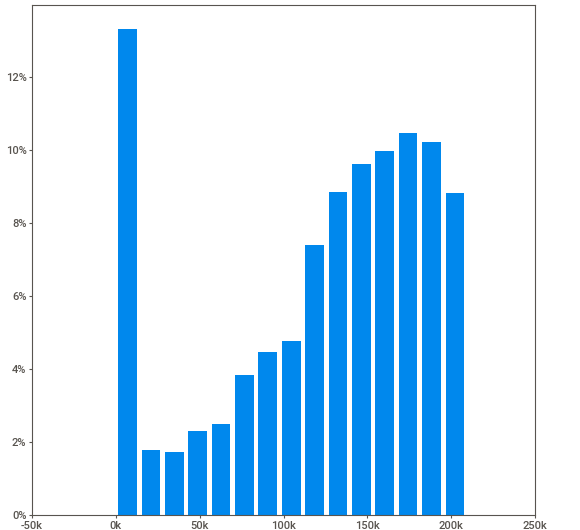
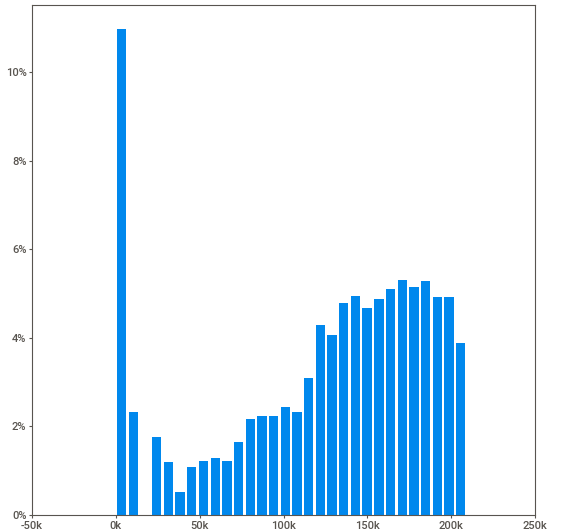
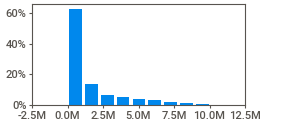
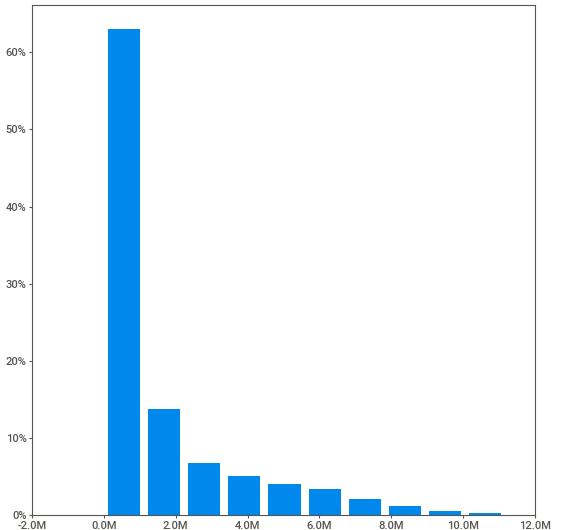
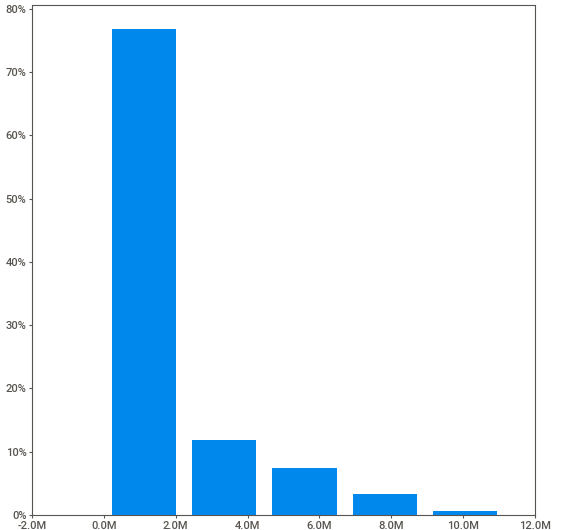
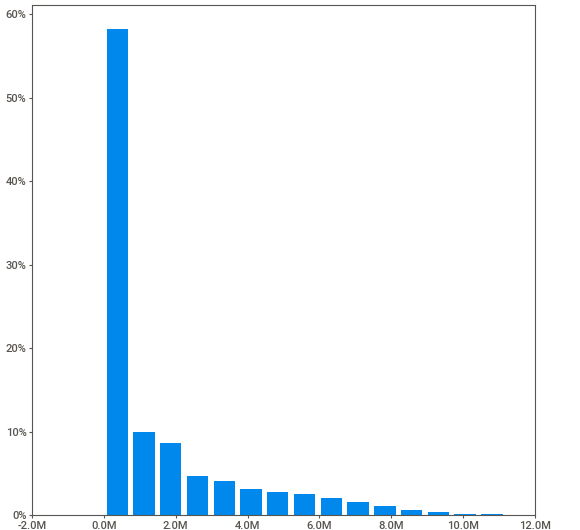
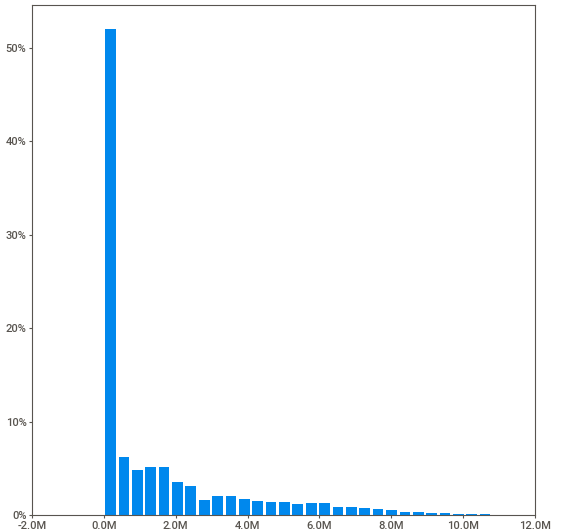
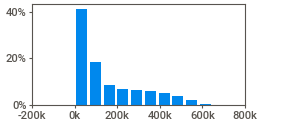
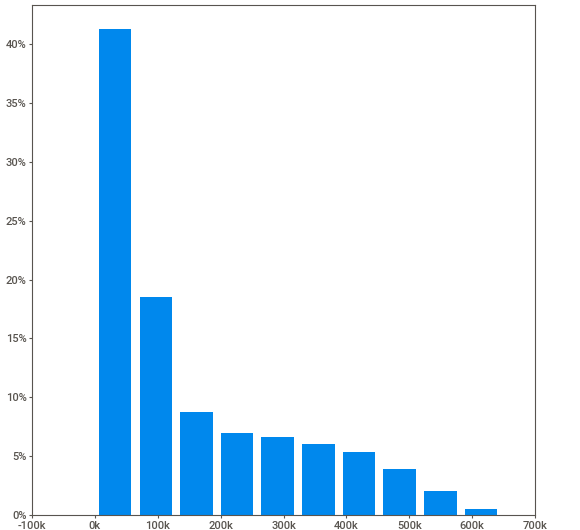
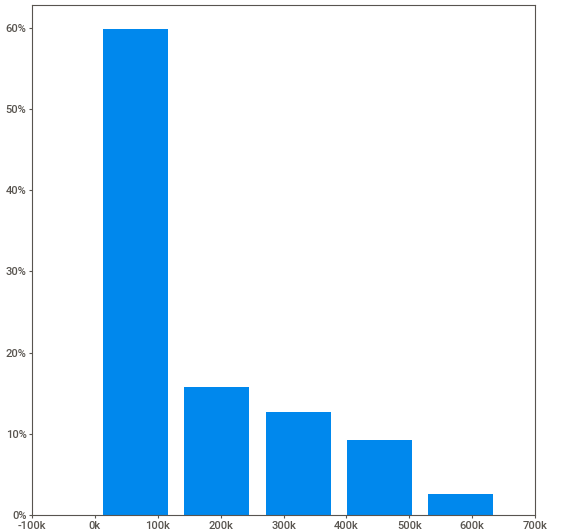
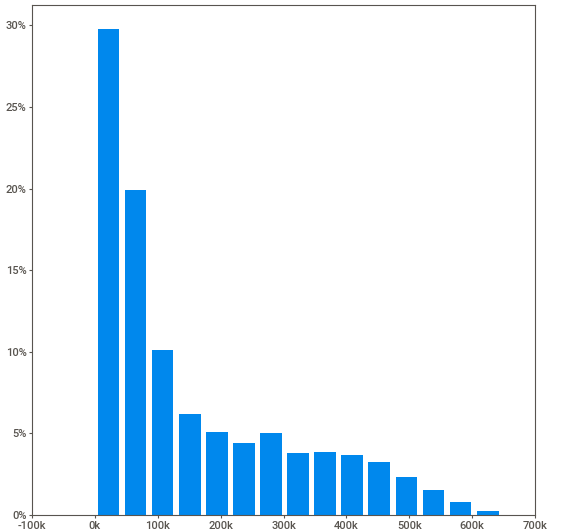
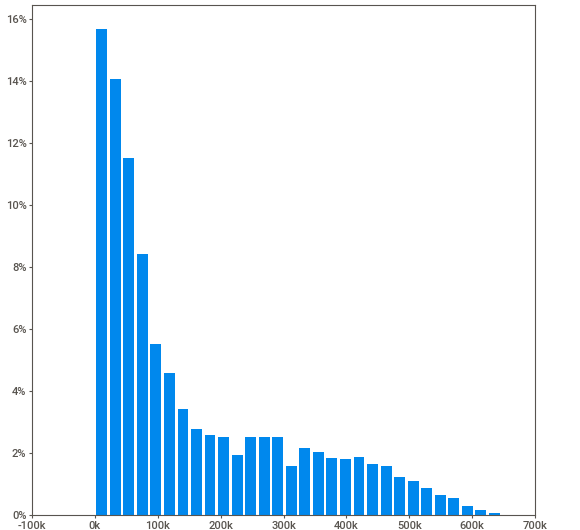
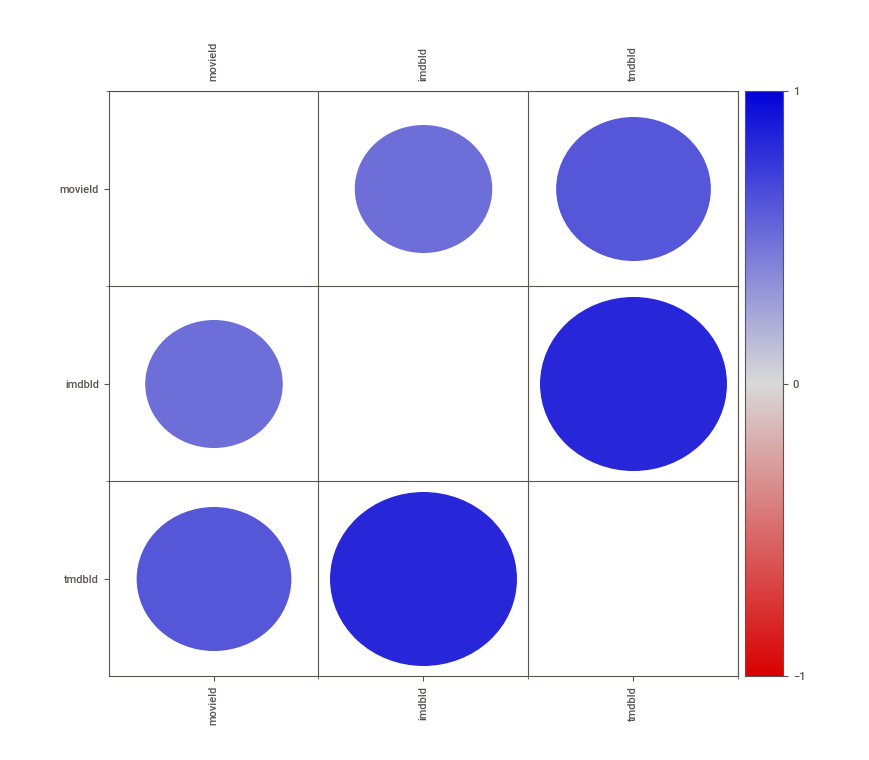
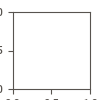

In [24]:
sv_links_report = sv.analyze(links)
sv_links_report.show_notebook()

                                             |          | [  0%]   00:00 -> (? left)


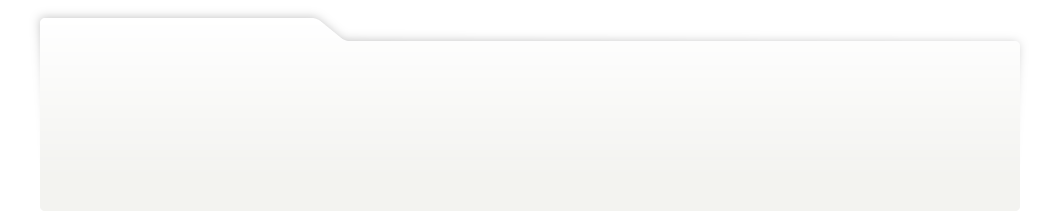
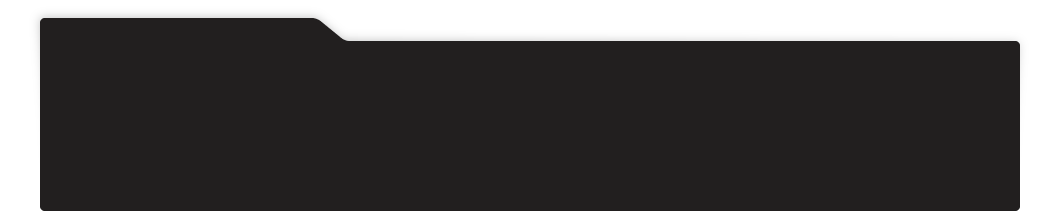
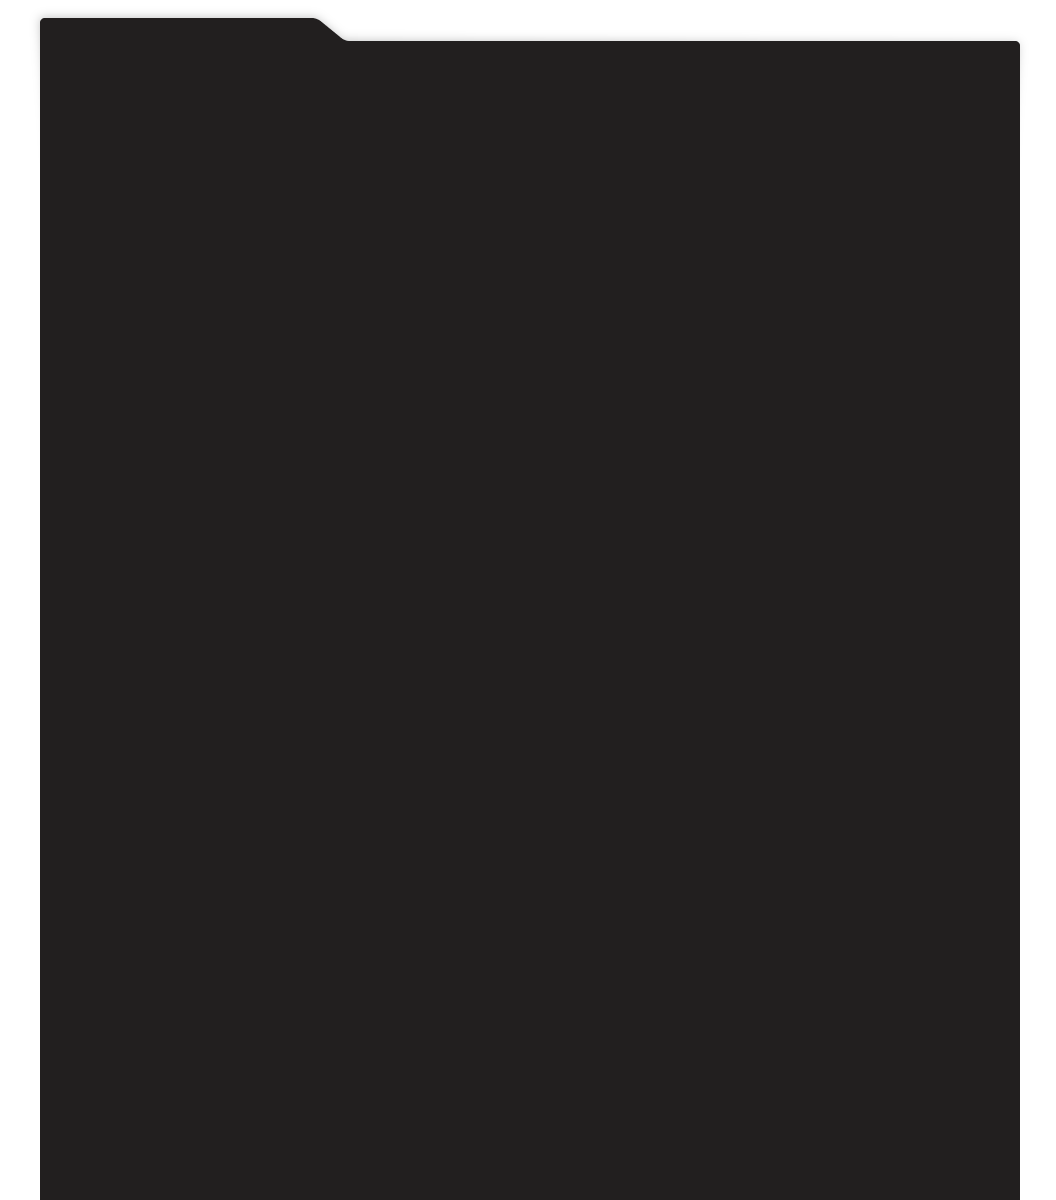
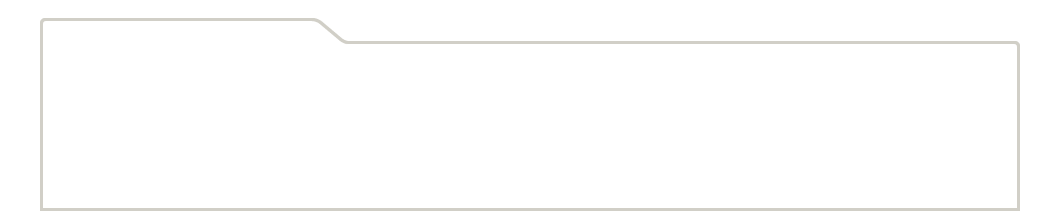
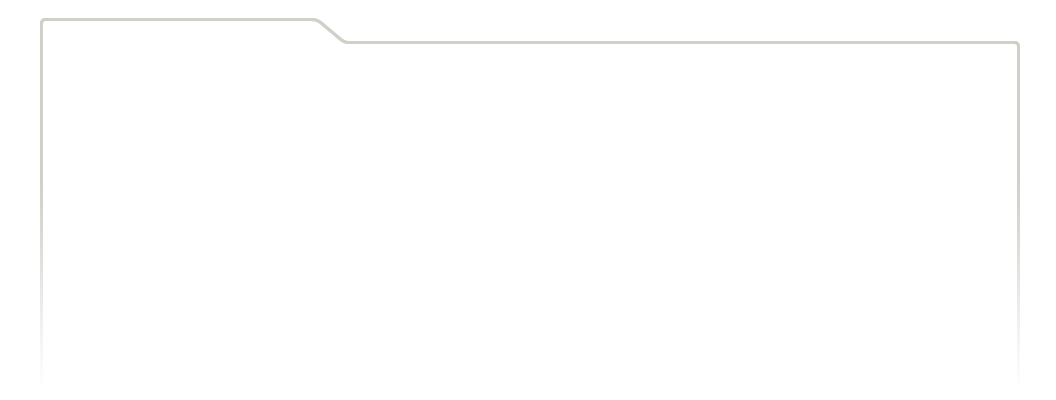
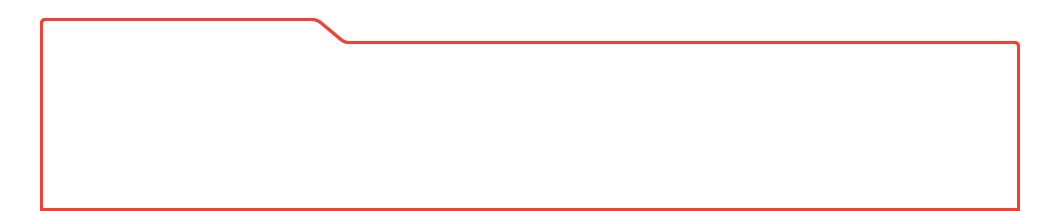
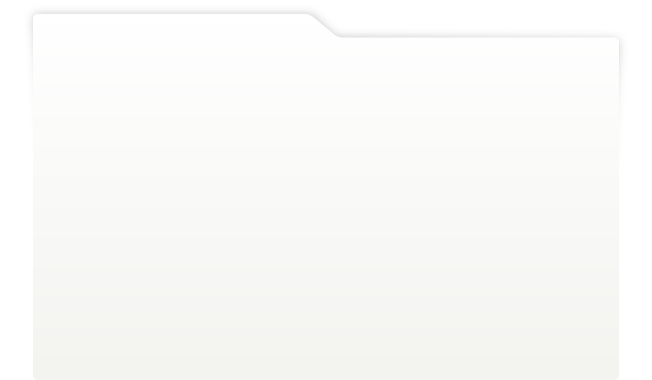
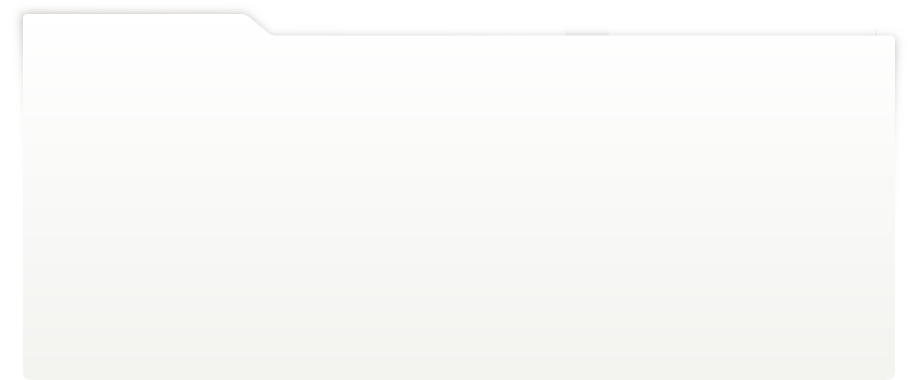
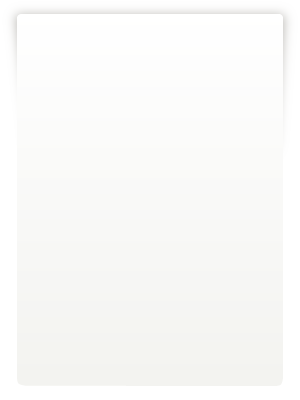
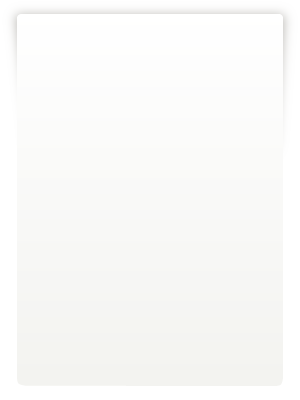
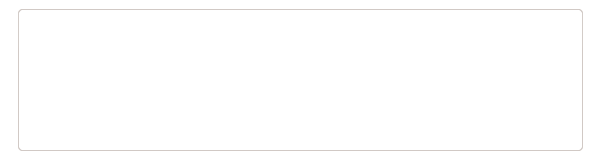
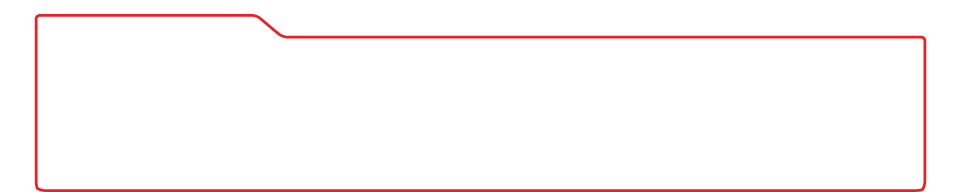
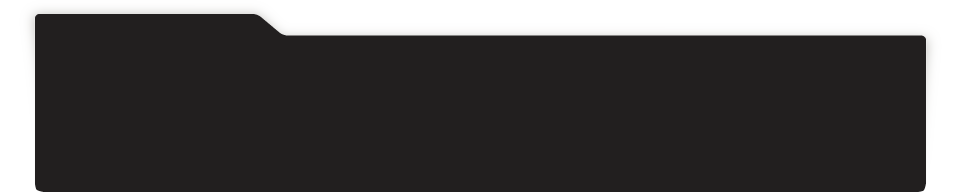
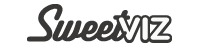
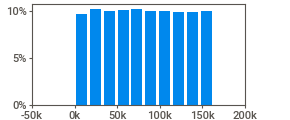
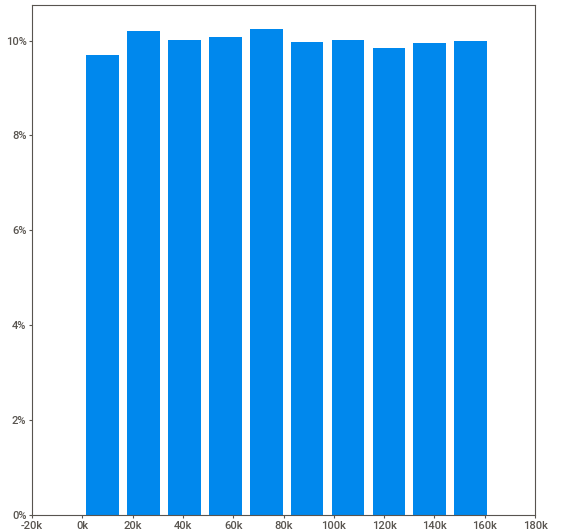
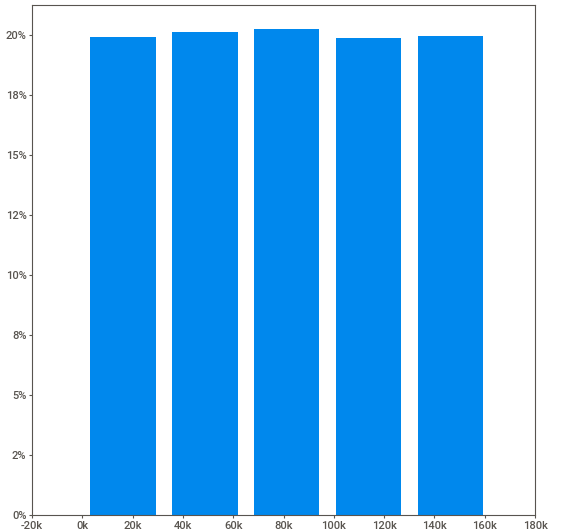
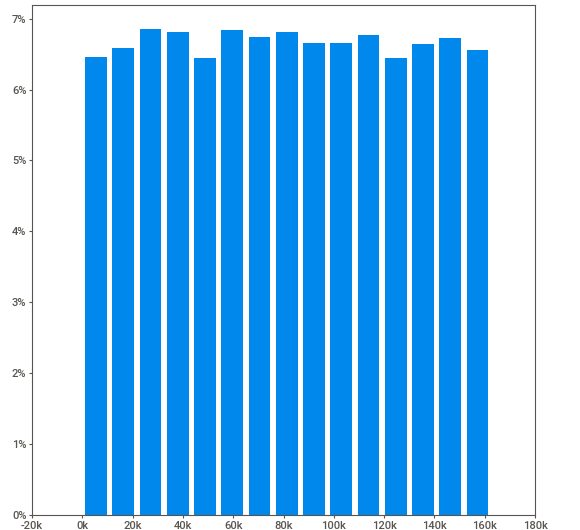
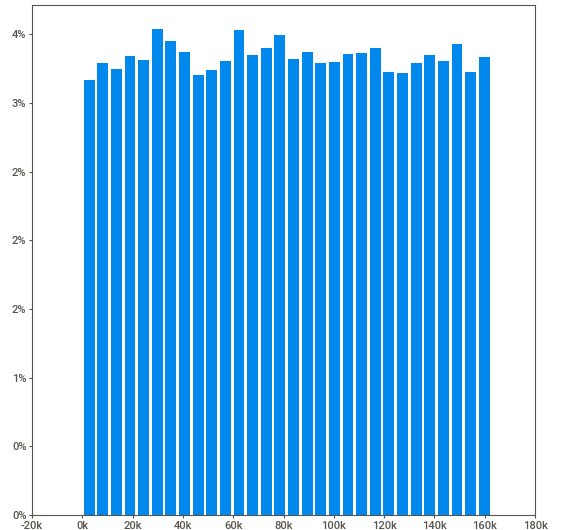
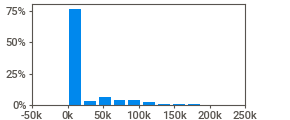
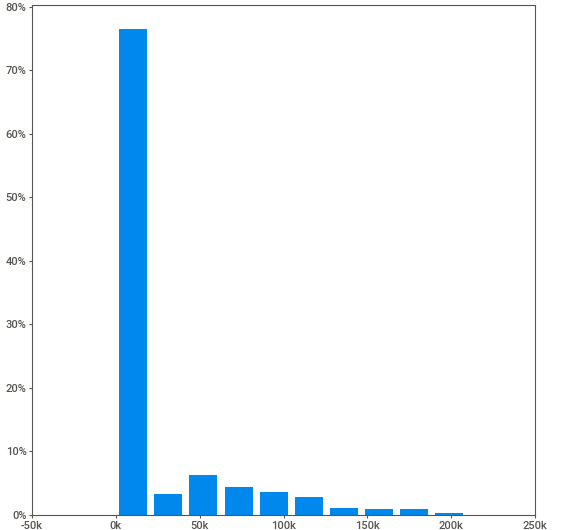
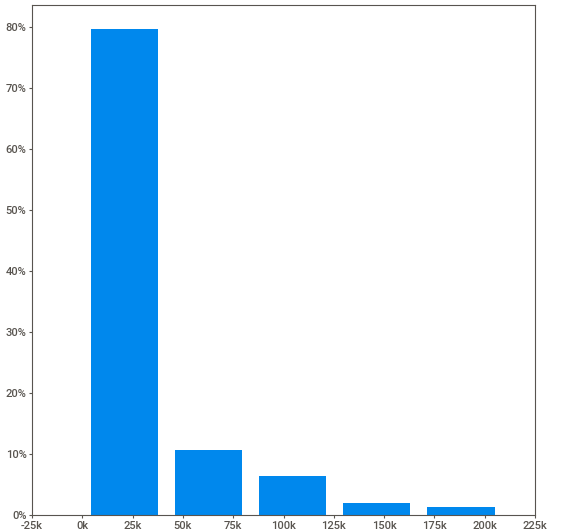
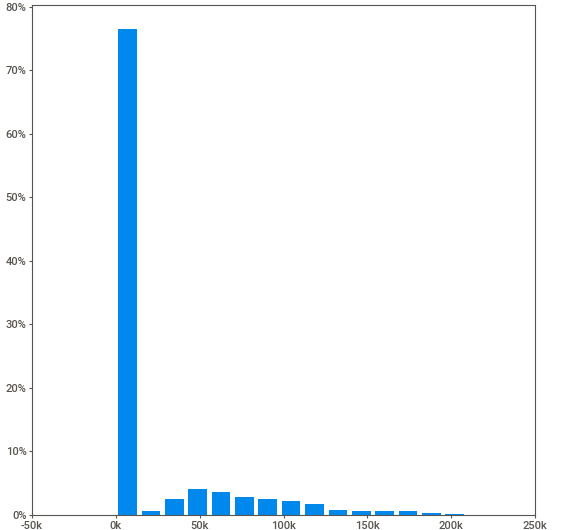
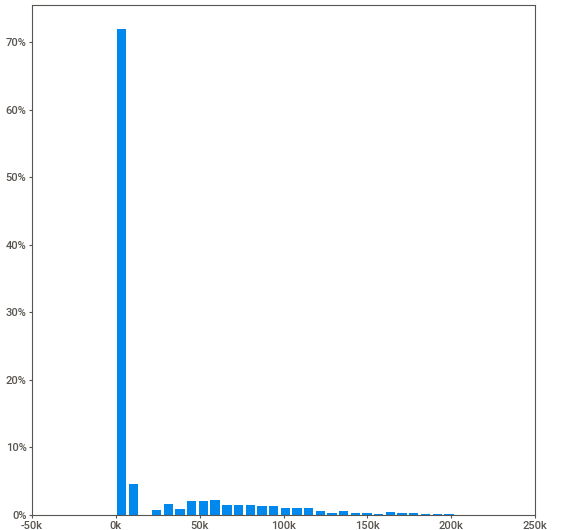
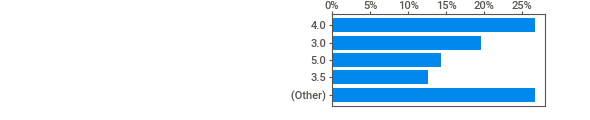
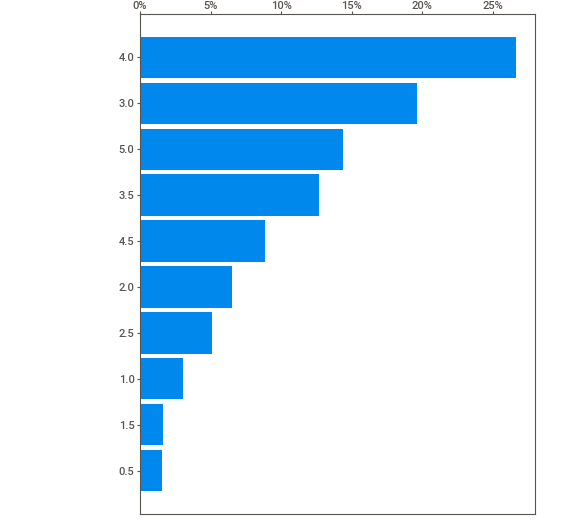
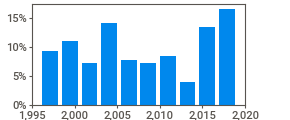
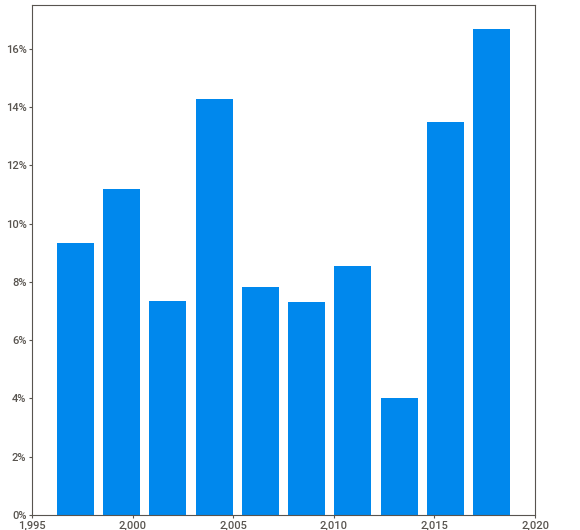
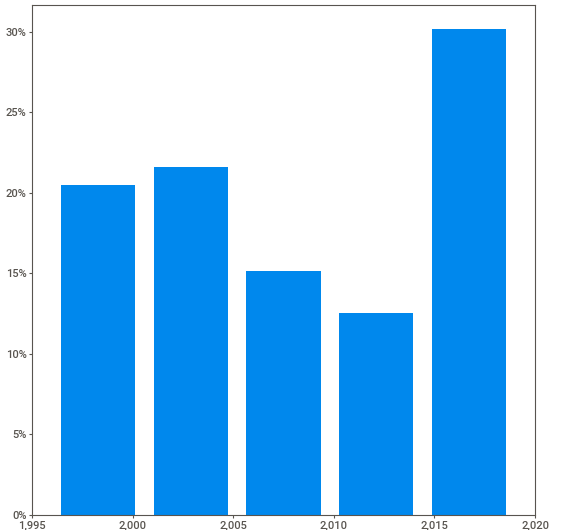
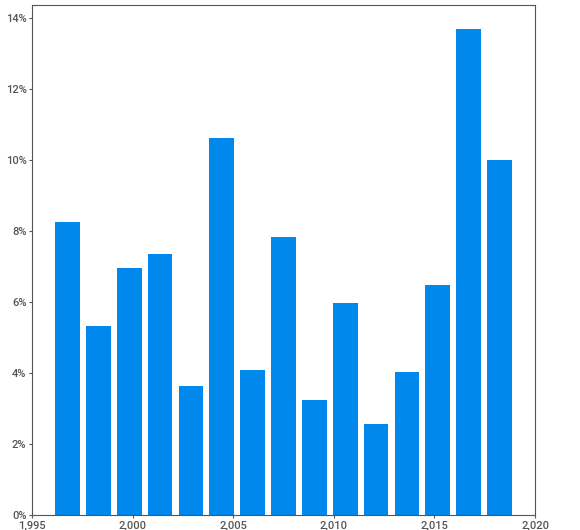
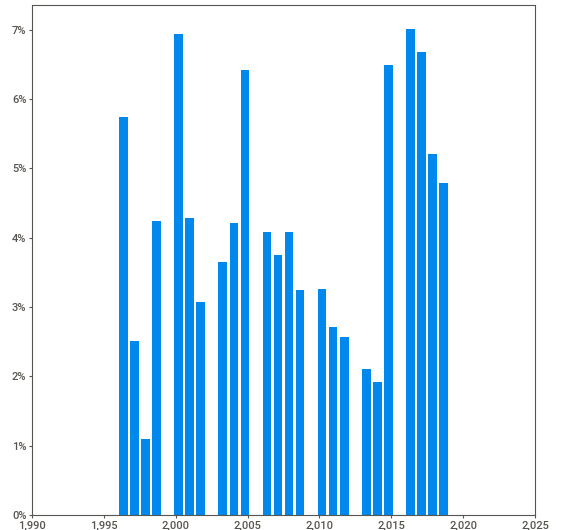
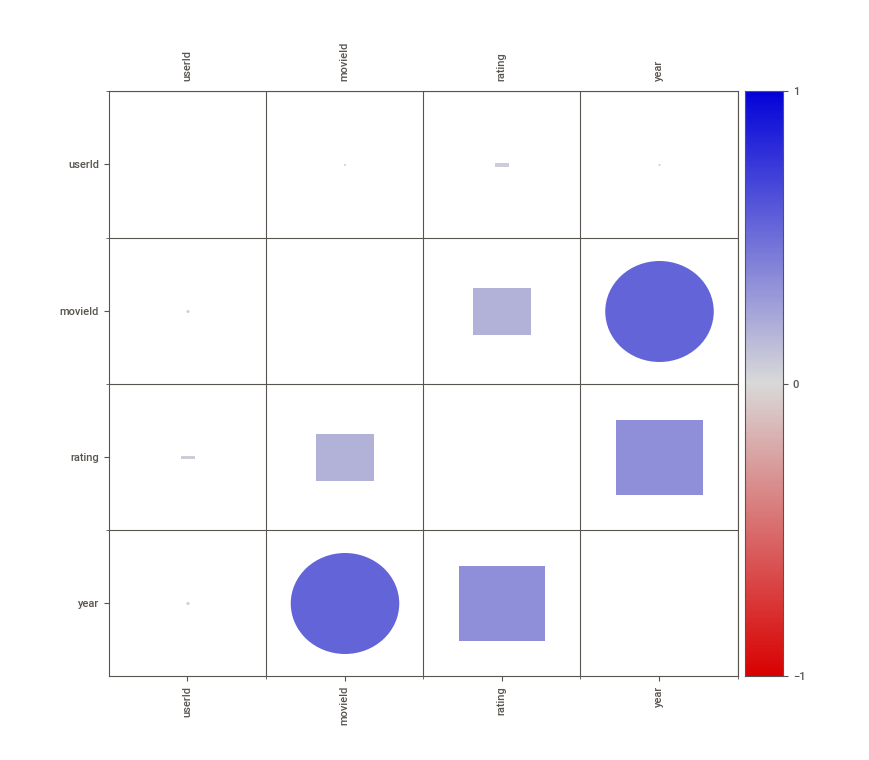
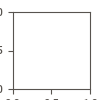

In [31]:
# sampling 1% of the data since it contains 25 million rows
sv_ratings_report = sv.analyze(ratings.sample(frac=0.01))
sv_ratings_report.show_notebook()

                                             |          | [  0%]   00:00 -> (? left)


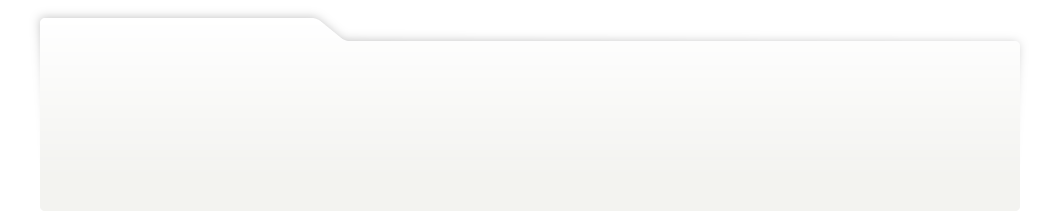
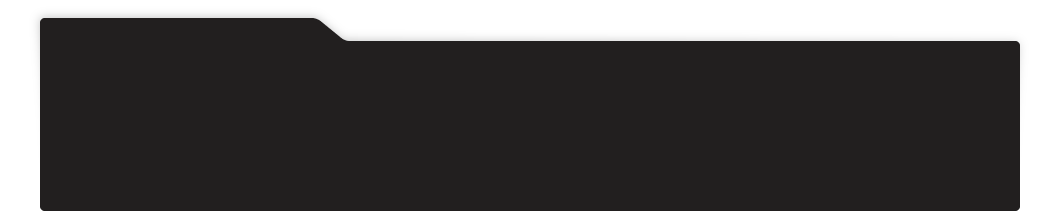
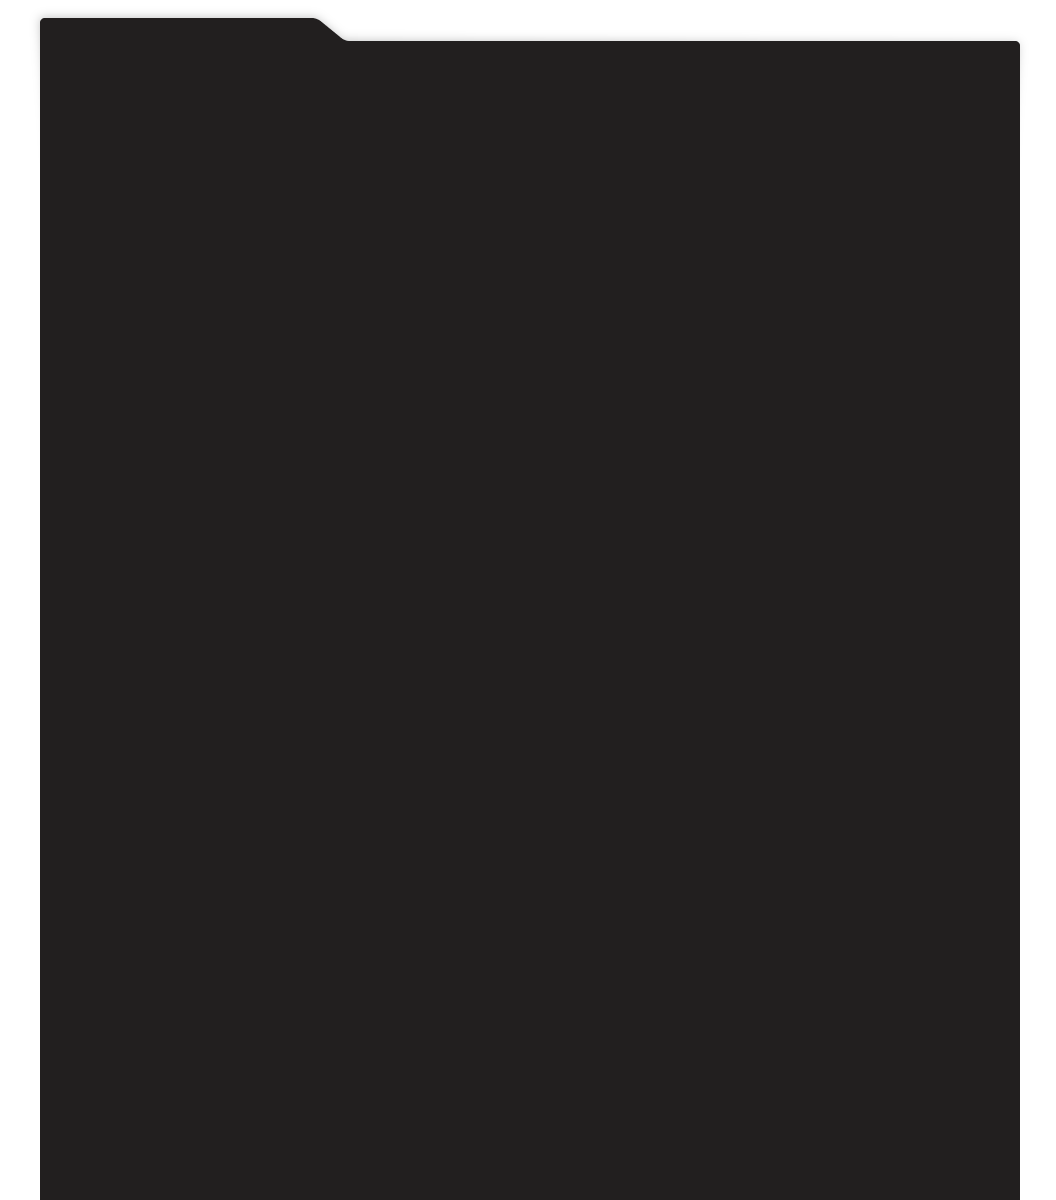
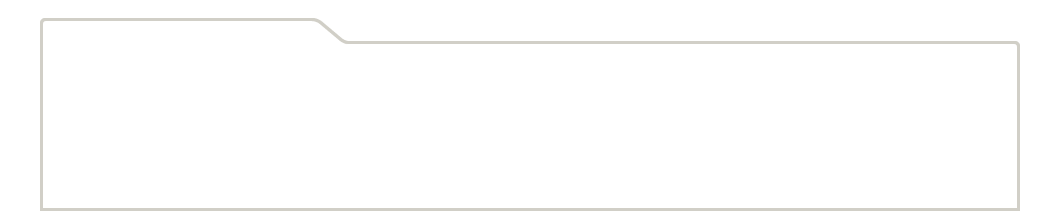
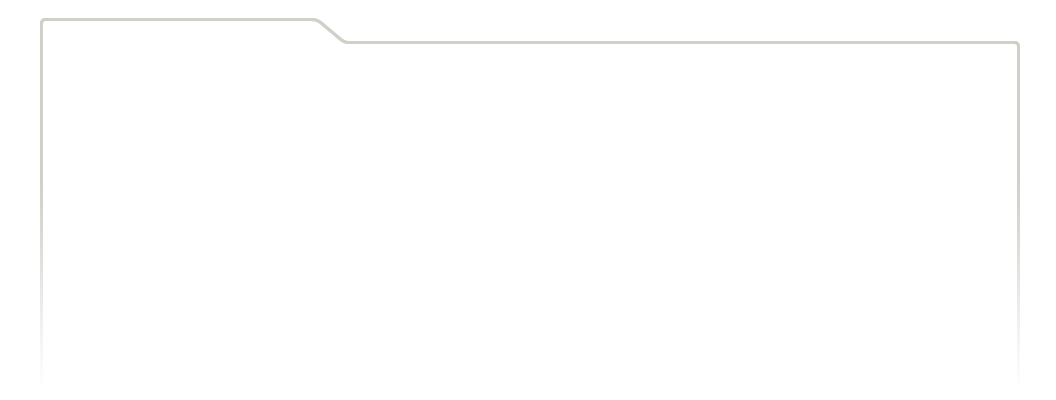
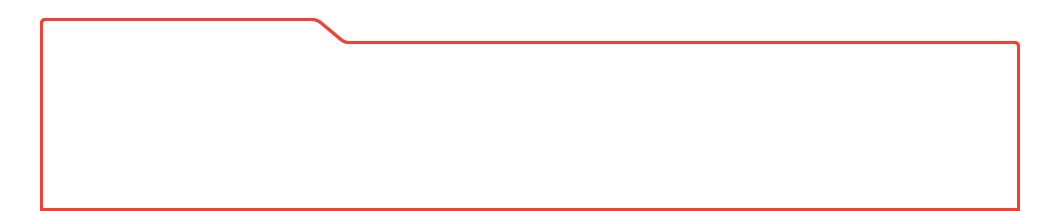
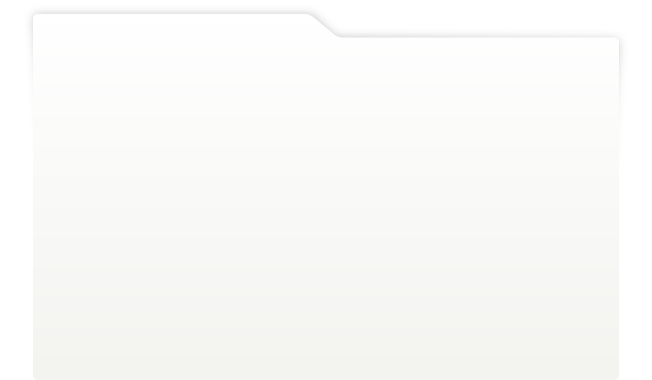
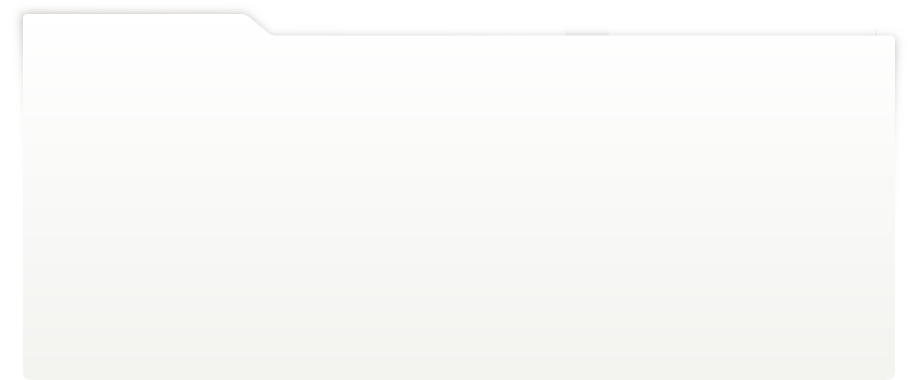
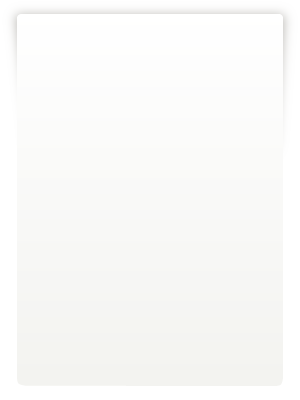
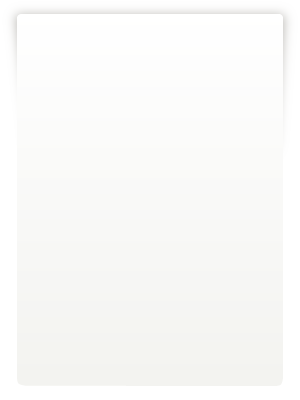
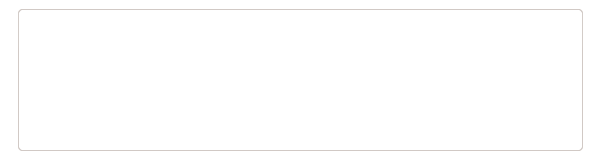
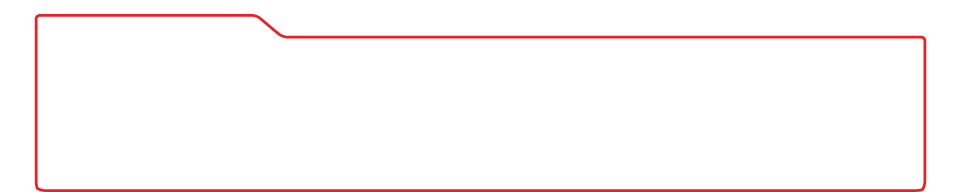
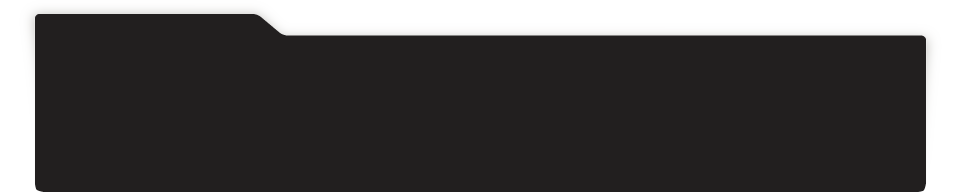
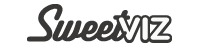
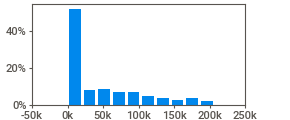
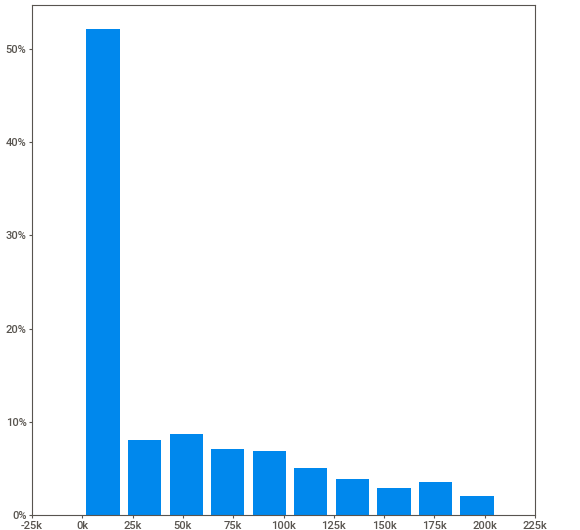
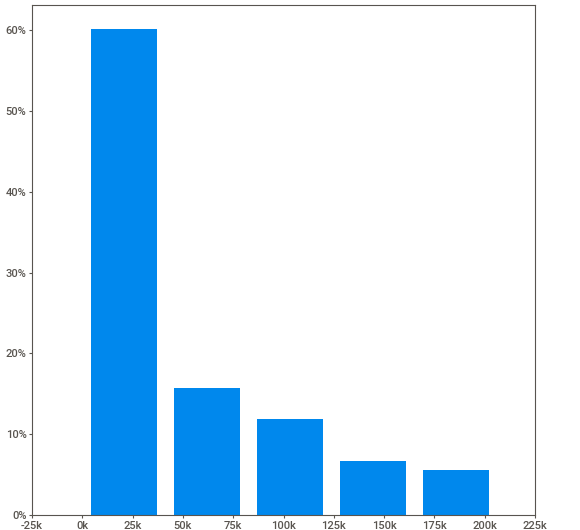
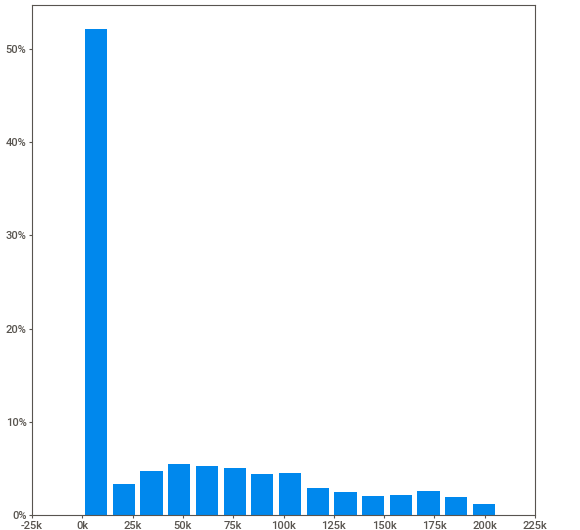
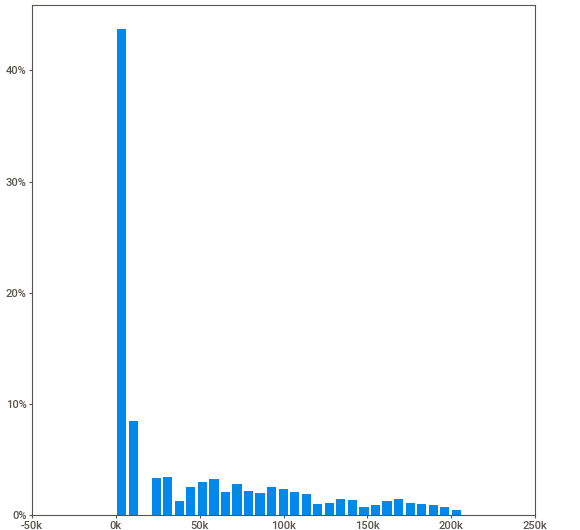
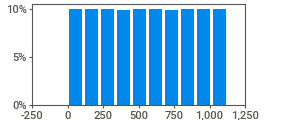
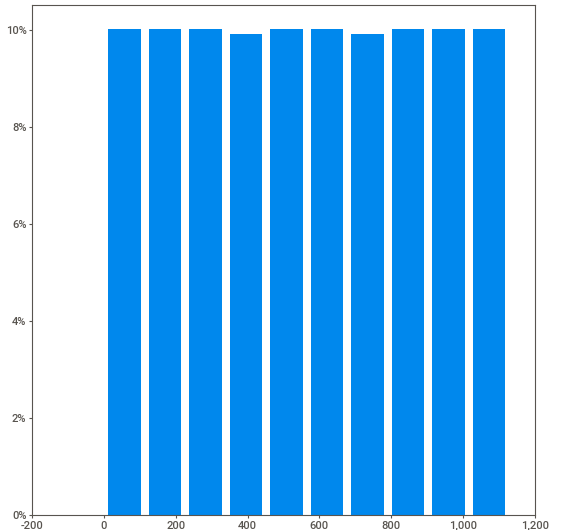
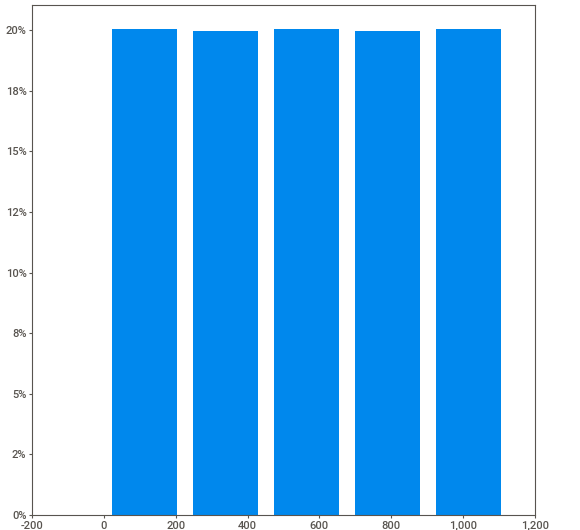
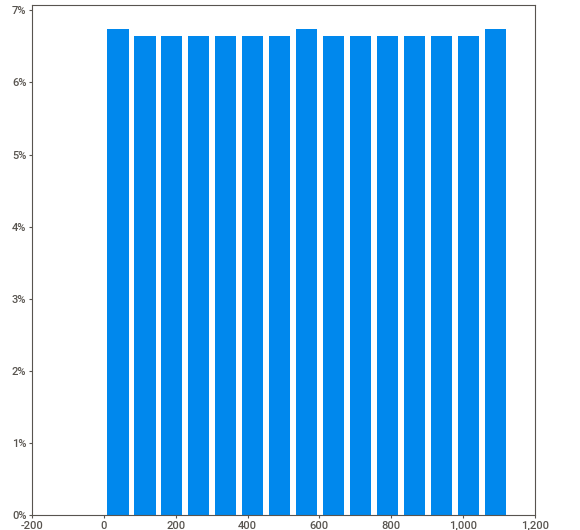
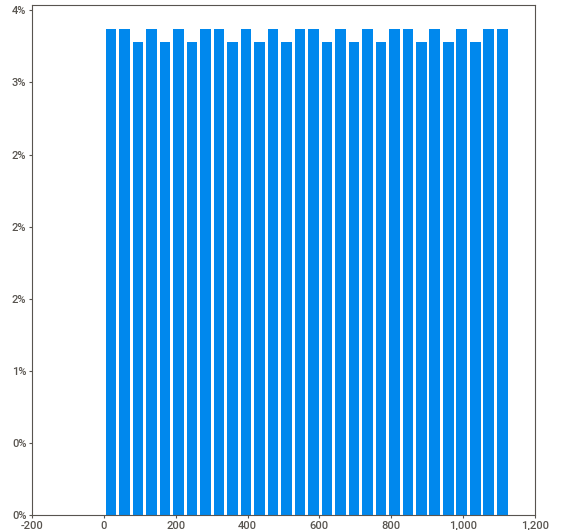
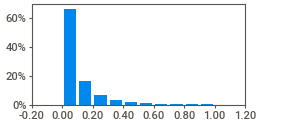
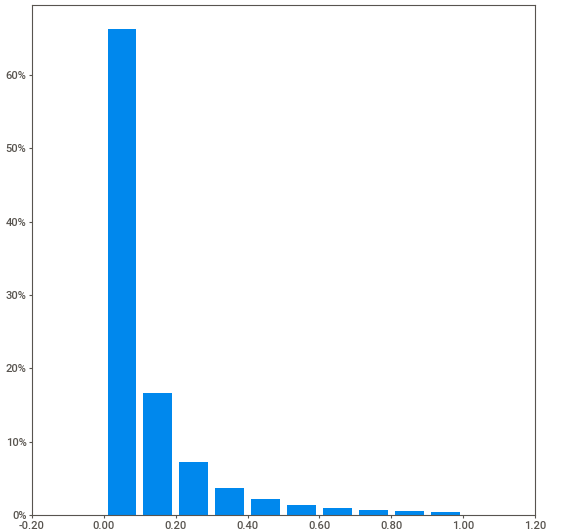
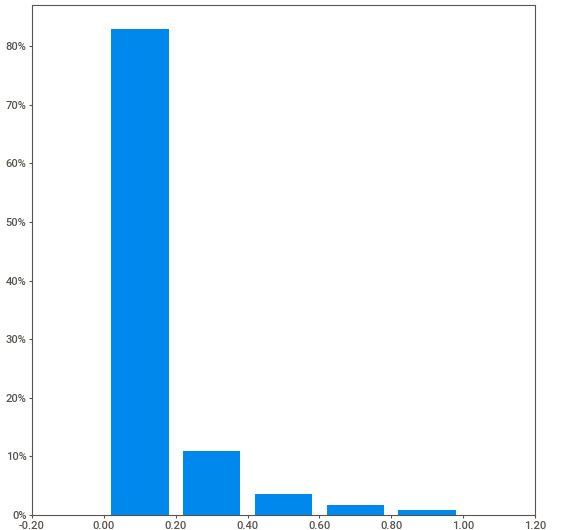
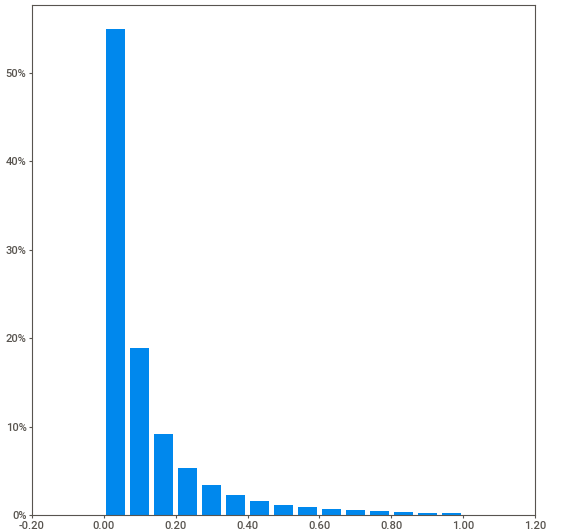
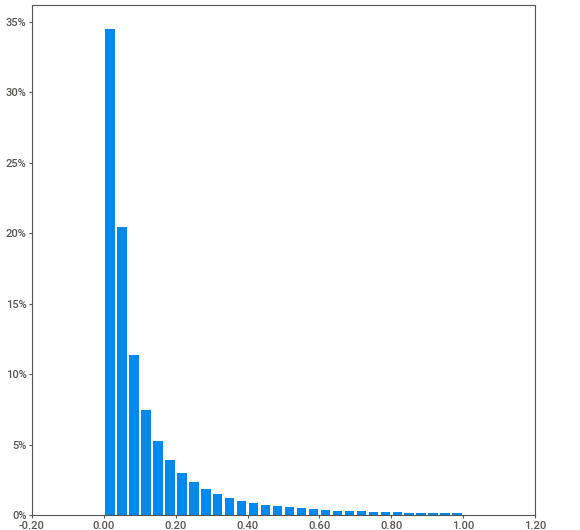
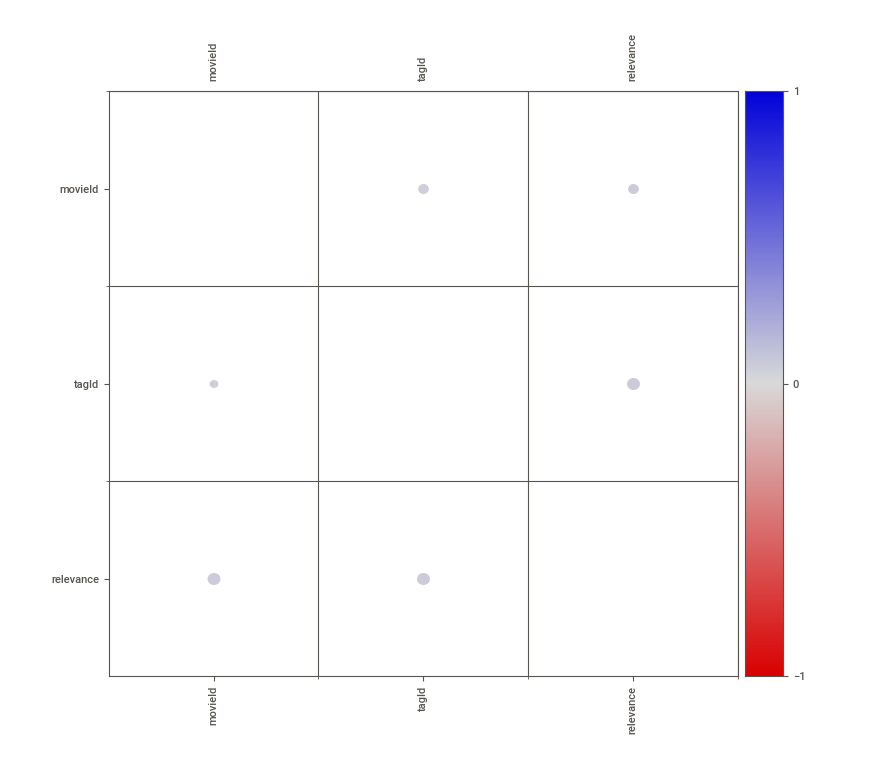
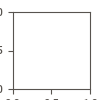

In [7]:
sv_genome_scores_report = sv.analyze(genome_scores)
sv_genome_scores_report.show_notebook()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d8c60091-34ab-41c2-8d44-4fbf2ff8f01b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>